# Step 4 - Extract Ratings
Using the Anilist and MyAnimeList APIs we can extract rating information for a given user

In [71]:
import pandas as pd
import requests
import json
import time

In [4]:
al_df = pd.read_csv(f'./data/anime_animelists_500000_10000.csv', delimiter=';', header=0)

In [57]:
al_df.head(6)

,ids,idtype,flair,site,sub
0,SonAnka,username,https://myanimelist.net/profile/SonAnka,MAL,anime
1,RiverSorcerer,username,https://myanimelist.net/profile/RiverSorcerer,MAL,anime
2,phiraeth,username,https://myanimelist.net/profile/phiraeth,MAL,anime
3,MoghyBear,username,https://myanimelist.net/profile/MoghyBear,MAL,anime
4,citatel,username,https://myanimelist.net/animelist/citatel,MAL,anime
5,FiveRumble,username,https://myanimelist.net/profile/FiveRumble,MAL,anime


In [145]:
al_df['site'].value_counts()

MAL        3780
anilist     599
Name: site, dtype: int64

## Extract MAL Ratings
We extract user ratings from MAL anime lists using the Jikan API

For future larger data queries, setup a local Jikan API: https://github.com/fethica/jikan-rest-docker

In [134]:
class RateLimit(object):
    def __init__(self, req_per_min, failed):
        self.rate = 60/req_per_min
        self.last_time = None
        self.failed = failed
        
    def rate_limit(self):  
        curr_time = time.time()
        if self.last_time:     
            diff = curr_time - self.last_time
            if diff >= self.rate:
                self.last_time = curr_time
            else:
                rl = self.rate - diff
                print(f'Rate Limiting, sleeping for {rl}s')
                time.sleep(rl)
                self.last_time = time.time()

        else:
            self.last_time = curr_time
        
    def req_fail(self):
        print(f'Request failed due to rate-limiting, sleeping for {self.failed}s')
        time.sleep(self.failed)

In [135]:
class MAL(object):
    _base_url = '{http}://{source}/v3/user/{{username}}/animelist/all/{{page}}'
    
    def __init__(self, req_per_min=30, max_retries=3, localhost=False, port=9000):
        self.max_retries = max_retries
        self.rl = RateLimit(req_per_min, 4)
        self.localhost = localhost
        self.port = port
        
    @property
    def base_url(self):
        # getter for base_url, with formatting
        if self.localhost:
            return self._base_url.format(http='http', source=f'localhost:{self.port}/public')
        else:
            return self._base_url.format(http='https', source='api.jikan.moe')

    # request MAL user anime lists
    def req(self, username):
        i = 1
        results = []
        last_time = None
        retries = 0

        while True:
            # implement rate-limiting
            self.rl.rate_limit()
            
            url = self.base_url.format(username=username,page=i)
            r = requests.get(url)
            status = r.status_code
            if status == 200:
                r = json.loads(r.text)
                anime = r['anime']
                if anime:
                    for obj in anime:
                        obj['username'] = username
                    results.extend(anime)
                else:
                    print(f'Finished retrieving anime ratings for {username}')
                    break
            elif status == 429:
                # additional rate-limiting
                self.rl.req_fail()
                retries +=1
                if retries > max_retries:
                    print(f'Maximum retries {max_retries} exceeded')
                    break
            elif status == 400:
                print(f'Request failed, an account cannot be found for {username}')
                break
            else:
                raise Exception(f'{r.text}')

            i += 1

        return results    

In [60]:
df = pd.DataFrame(mal_req('FiveRumble'))

Request failed, an account cannot be found for FiveRumble


In [93]:
mal_arr = []
mal_api = MAL()
for index, row in al_df.iterrows():
    username = row['ids']
    website = row['site']
    if website == 'MAL':
        results = mal_api.req(username)
        if results:
            mal_arr.extend(results)
mal_df = pd.DataFrame(mal_arr)

Rate Limiting, sleeping for 0.46056699752807617s
Finished retrieving anime ratings for SonAnka
Rate Limiting, sleeping for 1.1551971435546875s
Rate Limiting, sleeping for 0.26317477226257324s
Rate Limiting, sleeping for 1.1205127239227295s
Finished retrieving anime ratings for RiverSorcerer
Rate Limiting, sleeping for 0.8780403137207031s
Rate Limiting, sleeping for 0.28919506072998047s
Rate Limiting, sleeping for 0.3441500663757324s
Finished retrieving anime ratings for phiraeth
Rate Limiting, sleeping for 1.1577351093292236s
Rate Limiting, sleeping for 0.5850131511688232s
Finished retrieving anime ratings for MoghyBear
Rate Limiting, sleeping for 1.1684958934783936s
Rate Limiting, sleeping for 0.00960087776184082s
Rate Limiting, sleeping for 1.2001025676727295s
Finished retrieving anime ratings for citatel
Rate Limiting, sleeping for 1.1953136920928955s
Request failed, an account cannot be found for FiveRumble
Rate Limiting, sleeping for 1.643768310546875s
Rate Limiting, sleeping for 

Rate Limiting, sleeping for 0.4637417793273926s
Rate Limiting, sleeping for 1.4954917430877686s
Rate Limiting, sleeping for 1.4999158382415771s
Rate Limiting, sleeping for 1.5338406562805176s
Finished retrieving anime ratings for TheRiyria
Rate Limiting, sleeping for 1.6201260089874268s
Rate Limiting, sleeping for 0.4547157287597656s
Rate Limiting, sleeping for 1.5168397426605225s
Finished retrieving anime ratings for AniMonologues
Rate Limiting, sleeping for 1.632094383239746s
Rate Limiting, sleeping for 0.44339942932128906s
Finished retrieving anime ratings for Iskus
Rate Limiting, sleeping for 1.6412463188171387s
Rate Limiting, sleeping for 1.5100767612457275s
Rate Limiting, sleeping for 1.500251293182373s
Rate Limiting, sleeping for 1.528963327407837s
Finished retrieving anime ratings for Ac3Zer0
Rate Limiting, sleeping for 1.6364943981170654s
Rate Limiting, sleeping for 1.5313982963562012s
Finished retrieving anime ratings for csticks
Rate Limiting, sleeping for 1.6394634246826172

Rate Limiting, sleeping for 0.20477652549743652s
Rate Limiting, sleeping for 0.20730876922607422s
Rate Limiting, sleeping for 0.4161198139190674s
Rate Limiting, sleeping for 0.12457275390625s
Rate Limiting, sleeping for 0.30810022354125977s
Rate Limiting, sleeping for 0.04462623596191406s
Rate Limiting, sleeping for 0.3794257640838623s
Rate Limiting, sleeping for 0.2932393550872803s
Rate Limiting, sleeping for 0.4157729148864746s
Rate Limiting, sleeping for 0.4227614402770996s
Rate Limiting, sleeping for 0.4657158851623535s
Rate Limiting, sleeping for 0.2173786163330078s
Rate Limiting, sleeping for 0.12387752532958984s
Rate Limiting, sleeping for 0.34277915954589844s
Rate Limiting, sleeping for 0.4653773307800293s
Rate Limiting, sleeping for 0.4604156017303467s
Rate Limiting, sleeping for 0.9690518379211426s
Finished retrieving anime ratings for Vindstot
Rate Limiting, sleeping for 1.1964504718780518s
Rate Limiting, sleeping for 0.23975300788879395s
Rate Limiting, sleeping for 0.285842

Rate Limiting, sleeping for 1.0478367805480957s
Finished retrieving anime ratings for pieandchicken
Rate Limiting, sleeping for 1.21346116065979s
Rate Limiting, sleeping for 1.0977814197540283s
Finished retrieving anime ratings for DanoOnTheMoon
Rate Limiting, sleeping for 1.220566987991333s
Rate Limiting, sleeping for 0.5486154556274414s
Finished retrieving anime ratings for SleepingWolves
Rate Limiting, sleeping for 1.1395320892333984s
Rate Limiting, sleeping for 0.40560269355773926s
Rate Limiting, sleeping for 0.9318134784698486s
Finished retrieving anime ratings for 8_Pixels
Rate Limiting, sleeping for 1.2288329601287842s
Rate Limiting, sleeping for 0.2696988582611084s
Rate Limiting, sleeping for 0.279768705368042s
Finished retrieving anime ratings for PeanutMochi
Rate Limiting, sleeping for 1.1017603874206543s
Rate Limiting, sleeping for 1.1702005863189697s
Finished retrieving anime ratings for namespace
Rate Limiting, sleeping for 1.2217943668365479s
Rate Limiting, sleeping for 1

Finished retrieving anime ratings for FerdinandG
Rate Limiting, sleeping for 1.210735559463501s
Rate Limiting, sleeping for 0.41872668266296387s
Rate Limiting, sleeping for 0.6095108985900879s
Finished retrieving anime ratings for jediD15
Rate Limiting, sleeping for 1.1677024364471436s
Rate Limiting, sleeping for 0.45577430725097656s
Finished retrieving anime ratings for Streefied
Rate Limiting, sleeping for 1.1913647651672363s
Rate Limiting, sleeping for 0.6716310977935791s
Finished retrieving anime ratings for EMTIsBestWaifu
Rate Limiting, sleeping for 1.1667630672454834s
Rate Limiting, sleeping for 1.491666555404663s
Rate Limiting, sleeping for 1.5164990425109863s
Finished retrieving anime ratings for AntonRuscov
Rate Limiting, sleeping for 1.643775224685669s
Request failed, an account cannot be found for MehMcBoored
Rate Limiting, sleeping for 1.1774334907531738s
Finished retrieving anime ratings for Dimmadeezy
Rate Limiting, sleeping for 1.1181159019470215s
Rate Limiting, sleeping

Request failed, an account cannot be found for Mr_Mortus
Rate Limiting, sleeping for 1.2319402694702148s
Rate Limiting, sleeping for 0.9798450469970703s
Finished retrieving anime ratings for Jitszu
Rate Limiting, sleeping for 1.2139949798583984s
Rate Limiting, sleeping for 0.5462296009063721s
Finished retrieving anime ratings for Ioruko
Rate Limiting, sleeping for 1.1359100341796875s
Rate Limiting, sleeping for 1.044130802154541s
Finished retrieving anime ratings for Viesulis123
Rate Limiting, sleeping for 1.1500470638275146s
Rate Limiting, sleeping for 0.07871270179748535s
Rate Limiting, sleeping for 0.4862492084503174s
Finished retrieving anime ratings for JS_0420
Rate Limiting, sleeping for 1.1145999431610107s
Rate Limiting, sleeping for 0.4160592555999756s
Rate Limiting, sleeping for 1.1078441143035889s
Finished retrieving anime ratings for Lamby28
Rate Limiting, sleeping for 1.1436851024627686s
Rate Limiting, sleeping for 1.114837646484375s
Finished retrieving anime ratings for pr

Rate Limiting, sleeping for 0.3905754089355469s
Rate Limiting, sleeping for 0.9076826572418213s
Finished retrieving anime ratings for firestarness
Rate Limiting, sleeping for 1.1022627353668213s
Rate Limiting, sleeping for 0.3910255432128906s
Finished retrieving anime ratings for GravelsNotAFood
Rate Limiting, sleeping for 1.1054275035858154s
Request failed, an account cannot be found for hanr10
Rate Limiting, sleeping for 1.1600449085235596s
Rate Limiting, sleeping for 0.7207143306732178s
Finished retrieving anime ratings for MrRobzter
Rate Limiting, sleeping for 0.5926015377044678s
Rate Limiting, sleeping for 0.36338210105895996s
Rate Limiting, sleeping for 0.4639463424682617s
Finished retrieving anime ratings for Lilyvess
Rate Limiting, sleeping for 1.18550705909729s
Rate Limiting, sleeping for 1.1014785766601562s
Finished retrieving anime ratings for Hinloen
Rate Limiting, sleeping for 1.1905817985534668s
Rate Limiting, sleeping for 0.9976074695587158s
Finished retrieving anime rat

Rate Limiting, sleeping for 0.33751821517944336s
Rate Limiting, sleeping for 1.0038979053497314s
Finished retrieving anime ratings for kalinime
Rate Limiting, sleeping for 1.2278516292572021s
Rate Limiting, sleeping for 0.311420202255249s
Finished retrieving anime ratings for TomatoNinja6
Rate Limiting, sleeping for 0.9232175350189209s
Rate Limiting, sleeping for 0.23810124397277832s
Rate Limiting, sleeping for 0.43224573135375977s
Finished retrieving anime ratings for MozillaFennekin
Rate Limiting, sleeping for 1.224290132522583s
Rate Limiting, sleeping for 1.131105661392212s
Finished retrieving anime ratings for Vilefighter
Rate Limiting, sleeping for 0.99336838722229s
Rate Limiting, sleeping for 0.5096814632415771s
Rate Limiting, sleeping for 0.49947595596313477s
Rate Limiting, sleeping for 1.0925700664520264s
Finished retrieving anime ratings for Brolaub
Rate Limiting, sleeping for 1.243276596069336s
Rate Limiting, sleeping for 0.4648251533508301s
Rate Limiting, sleeping for 0.7506

Request failed, an account cannot be found for TheTrueChazzy
Rate Limiting, sleeping for 1.1713910102844238s
Rate Limiting, sleeping for 0.6453988552093506s
Finished retrieving anime ratings for AgreeableTruck
Rate Limiting, sleeping for 1.2175912857055664s
Rate Limiting, sleeping for 0.40634894371032715s
Rate Limiting, sleeping for 0.6193528175354004s
Finished retrieving anime ratings for Orix
Rate Limiting, sleeping for 1.1465330123901367s
Request failed, an account cannot be found for itsvanxo
Rate Limiting, sleeping for 1.215278148651123s
Rate Limiting, sleeping for 0.8003847599029541s
Finished retrieving anime ratings for Hugo0o0
Rate Limiting, sleeping for 1.133180856704712s
Rate Limiting, sleeping for 1.048163890838623s
Finished retrieving anime ratings for Shimmering
Rate Limiting, sleeping for 1.1897485256195068s
Request failed, an account cannot be found for vuyo1993
Rate Limiting, sleeping for 1.1507327556610107s
Rate Limiting, sleeping for 1.0358388423919678s
Finished retri

Finished retrieving anime ratings for OneEyedKing808
Rate Limiting, sleeping for 1.1201772689819336s
Rate Limiting, sleeping for 0.44013452529907227s
Rate Limiting, sleeping for 1.0693721771240234s
Finished retrieving anime ratings for SirAwesomeness
Rate Limiting, sleeping for 1.173177719116211s
Rate Limiting, sleeping for 1.5015277862548828s
Rate Limiting, sleeping for 1.621476173400879s
Finished retrieving anime ratings for TDaotje
Rate Limiting, sleeping for 1.635258674621582s
Rate Limiting, sleeping for 0.6658716201782227s
Finished retrieving anime ratings for vivliz
Rate Limiting, sleeping for 1.2093710899353027s
Rate Limiting, sleeping for 0.32638120651245117s
Rate Limiting, sleeping for 0.33469462394714355s
Finished retrieving anime ratings for LegitPancake
Rate Limiting, sleeping for 0.913785457611084s
Request failed, an account cannot be found for maddi_osamu
Rate Limiting, sleeping for 1.255061388015747s
Rate Limiting, sleeping for 0.9664416313171387s
Finished retrieving ani

Rate Limiting, sleeping for 0.9441144466400146s
Finished retrieving anime ratings for Msc125
Rate Limiting, sleeping for 1.2213847637176514s
Rate Limiting, sleeping for 0.0638895034790039s
Rate Limiting, sleeping for 1.0721476078033447s
Finished retrieving anime ratings for Julius_Seizure77
Rate Limiting, sleeping for 1.2043757438659668s
Rate Limiting, sleeping for 0.5842947959899902s
Finished retrieving anime ratings for Endrance88
Rate Limiting, sleeping for 1.2178902626037598s
Rate Limiting, sleeping for 0.2270493507385254s
Rate Limiting, sleeping for 0.3643202781677246s
Rate Limiting, sleeping for 1.1402781009674072s
Finished retrieving anime ratings for radiax10
Rate Limiting, sleeping for 1.002039909362793s
Rate Limiting, sleeping for 0.6499252319335938s
Finished retrieving anime ratings for vollizie
Rate Limiting, sleeping for 1.208003044128418s
Rate Limiting, sleeping for 0.3346705436706543s
Finished retrieving anime ratings for mateo72
Rate Limiting, sleeping for 1.15885305404

Rate Limiting, sleeping for 0.7035946846008301s
Finished retrieving anime ratings for Zachk
Rate Limiting, sleeping for 1.1928787231445312s
Rate Limiting, sleeping for 0.5208640098571777s
Rate Limiting, sleeping for 1.0268771648406982s
Finished retrieving anime ratings for GimmeDatGrimoire
Rate Limiting, sleeping for 1.1972134113311768s
Rate Limiting, sleeping for 0.27849745750427246s
Rate Limiting, sleeping for 0.46555447578430176s
Rate Limiting, sleeping for 0.5080718994140625s
Rate Limiting, sleeping for 0.8623013496398926s
Finished retrieving anime ratings for Damarugaki
Rate Limiting, sleeping for 0.7216181755065918s
Rate Limiting, sleeping for 0.02988433837890625s
Rate Limiting, sleeping for 0.31240200996398926s
Finished retrieving anime ratings for Ozu2Stock
Rate Limiting, sleeping for 1.2180414199829102s
Rate Limiting, sleeping for 0.18244075775146484s
Rate Limiting, sleeping for 0.30152225494384766s
Finished retrieving anime ratings for Theleux
Rate Limiting, sleeping for 1.09

Rate Limiting, sleeping for 0.365067720413208s
Finished retrieving anime ratings for Smudy
Rate Limiting, sleeping for 1.1515684127807617s
Rate Limiting, sleeping for 0.0774078369140625s
Rate Limiting, sleeping for 0.8261444568634033s
Finished retrieving anime ratings for ctheturk
Rate Limiting, sleeping for 1.227128028869629s
Rate Limiting, sleeping for 0.46135497093200684s
Rate Limiting, sleeping for 0.5172913074493408s
Finished retrieving anime ratings for theawesome988
Rate Limiting, sleeping for 0.6349031925201416s
Rate Limiting, sleeping for 0.37144970893859863s
Finished retrieving anime ratings for revvoo
Rate Limiting, sleeping for 1.187685489654541s
Rate Limiting, sleeping for 0.22391128540039062s
Finished retrieving anime ratings for AmpFile
Rate Limiting, sleeping for 0.8883204460144043s
Rate Limiting, sleeping for 0.41316866874694824s
Rate Limiting, sleeping for 0.5692338943481445s
Rate Limiting, sleeping for 1.0143976211547852s
Finished retrieving anime ratings for kyriane

Rate Limiting, sleeping for 0.37642884254455566s
Finished retrieving anime ratings for ktomp41
Rate Limiting, sleeping for 1.2165677547454834s
Rate Limiting, sleeping for 0.19911694526672363s
Rate Limiting, sleeping for 0.21611428260803223s
Rate Limiting, sleeping for 0.29657936096191406s
Rate Limiting, sleeping for 0.34282493591308594s
Rate Limiting, sleeping for 0.12611961364746094s
Rate Limiting, sleeping for 0.15985441207885742s
Rate Limiting, sleeping for 0.17198705673217773s
Rate Limiting, sleeping for 0.1280808448791504s
Rate Limiting, sleeping for 0.13140010833740234s
Rate Limiting, sleeping for 0.004773855209350586s
Rate Limiting, sleeping for 0.21944451332092285s
Rate Limiting, sleeping for 0.31102490425109863s
Rate Limiting, sleeping for 0.1618812084197998s
Rate Limiting, sleeping for 0.08523344993591309s
Rate Limiting, sleeping for 0.0984046459197998s
Rate Limiting, sleeping for 0.1972665786743164s
Rate Limiting, sleeping for 0.3569149971008301s
Rate Limiting, sleeping for 

Rate Limiting, sleeping for 0.2246873378753662s
Rate Limiting, sleeping for 0.04711270332336426s
Finished retrieving anime ratings for enrap
Rate Limiting, sleeping for 1.1967902183532715s
Rate Limiting, sleeping for 0.28694844245910645s
Rate Limiting, sleeping for 0.38118553161621094s
Rate Limiting, sleeping for 0.23494553565979004s
Rate Limiting, sleeping for 0.47359275817871094s
Rate Limiting, sleeping for 0.5126700401306152s
Finished retrieving anime ratings for Isorn
Rate Limiting, sleeping for 1.1161179542541504s
Request failed, an account cannot be found for bernas3000
Rate Limiting, sleeping for 0.844567060470581s
Request failed, an account cannot be found for Mihneass
Rate Limiting, sleeping for 0.9655816555023193s
Request failed, an account cannot be found for Jack_Harper
Rate Limiting, sleeping for 0.9156432151794434s
Rate Limiting, sleeping for 1.0823414325714111s
Finished retrieving anime ratings for PeckBackwards
Rate Limiting, sleeping for 1.1548502445220947s
Rate Limiti

Rate Limiting, sleeping for 0.5823650360107422s
Finished retrieving anime ratings for TopoR
Rate Limiting, sleeping for 1.1074225902557373s
Rate Limiting, sleeping for 0.2439584732055664s
Rate Limiting, sleeping for 1.0816013813018799s
Finished retrieving anime ratings for raszero
Rate Limiting, sleeping for 0.8631904125213623s
Rate Limiting, sleeping for 0.272402286529541s
Rate Limiting, sleeping for 1.217360496520996s
Finished retrieving anime ratings for RealMoonMoon
Rate Limiting, sleeping for 1.1166741847991943s
Rate Limiting, sleeping for 0.36293673515319824s
Rate Limiting, sleeping for 0.9813506603240967s
Finished retrieving anime ratings for thacheeseburger
Rate Limiting, sleeping for 0.919992208480835s
Rate Limiting, sleeping for 0.9931445121765137s
Finished retrieving anime ratings for SakuraFlowers24
Rate Limiting, sleeping for 1.1752185821533203s
Rate Limiting, sleeping for 0.704946756362915s
Finished retrieving anime ratings for ryorp
Rate Limiting, sleeping for 1.22029948

Rate Limiting, sleeping for 0.4710507392883301s
Rate Limiting, sleeping for 0.4596548080444336s
Finished retrieving anime ratings for Cosmic_Penguin
Rate Limiting, sleeping for 0.8396561145782471s
Rate Limiting, sleeping for 0.5068066120147705s
Finished retrieving anime ratings for animeman12345
Rate Limiting, sleeping for 1.2099792957305908s
Rate Limiting, sleeping for 0.7131950855255127s
Finished retrieving anime ratings for neel_verma123
Rate Limiting, sleeping for 1.036323070526123s
Request failed, an account cannot be found for daanish_yagami
Rate Limiting, sleeping for 1.146432876586914s
Rate Limiting, sleeping for 0.3356473445892334s
Rate Limiting, sleeping for 0.9933416843414307s
Finished retrieving anime ratings for rand_username
Rate Limiting, sleeping for 0.8206865787506104s
Rate Limiting, sleeping for 0.9878270626068115s
Finished retrieving anime ratings for ThieVuz
Rate Limiting, sleeping for 1.2340006828308105s
Rate Limiting, sleeping for 0.4854319095611572s
Rate Limiting

Rate Limiting, sleeping for 0.13811755180358887s
Rate Limiting, sleeping for 1.1444766521453857s
Finished retrieving anime ratings for Gonikku
Rate Limiting, sleeping for 1.1248693466186523s
Rate Limiting, sleeping for 0.8688607215881348s
Finished retrieving anime ratings for ben99ny
Rate Limiting, sleeping for 1.220440149307251s
Rate Limiting, sleeping for 0.07355356216430664s
Rate Limiting, sleeping for 0.09519696235656738s
Rate Limiting, sleeping for 0.012596607208251953s
Rate Limiting, sleeping for 0.0745084285736084s
Finished retrieving anime ratings for Grest
Rate Limiting, sleeping for 1.1299028396606445s
Rate Limiting, sleeping for 0.1264793872833252s
Rate Limiting, sleeping for 0.26462411880493164s
Rate Limiting, sleeping for 0.9752116203308105s
Finished retrieving anime ratings for LakerBlue
Rate Limiting, sleeping for 0.8209974765777588s
Request failed, an account cannot be found for Qwterty
Rate Limiting, sleeping for 1.1067099571228027s
Rate Limiting, sleeping for 0.983808

Rate Limiting, sleeping for 0.31508970260620117s
Rate Limiting, sleeping for 1.1249783039093018s
Finished retrieving anime ratings for Dilacerate
Rate Limiting, sleeping for 1.1897084712982178s
Rate Limiting, sleeping for 0.3412318229675293s
Rate Limiting, sleeping for 0.5078668594360352s
Finished retrieving anime ratings for PenguinPwnge
Rate Limiting, sleeping for 1.0902459621429443s
Request failed, an account cannot be found for bineet11
Rate Limiting, sleeping for 1.1797752380371094s
Rate Limiting, sleeping for 0.3460254669189453s
Rate Limiting, sleeping for 0.7806751728057861s
Finished retrieving anime ratings for Mevious
Rate Limiting, sleeping for 1.1132683753967285s
Rate Limiting, sleeping for 1.1121587753295898s
Finished retrieving anime ratings for girlfriendluvr
Rate Limiting, sleeping for 1.1658999919891357s
Rate Limiting, sleeping for 0.3765254020690918s
Rate Limiting, sleeping for 0.2474076747894287s
Rate Limiting, sleeping for 0.2895040512084961s
Rate Limiting, sleeping 

Rate Limiting, sleeping for 0.15497946739196777s
Finished retrieving anime ratings for Hades_MAL
Rate Limiting, sleeping for 1.084214448928833s
Rate Limiting, sleeping for 0.32558727264404297s
Rate Limiting, sleeping for 0.5434205532073975s
Finished retrieving anime ratings for pblivingston91
Rate Limiting, sleeping for 1.181403636932373s
Rate Limiting, sleeping for 0.34333372116088867s
Rate Limiting, sleeping for 0.46475648880004883s
Rate Limiting, sleeping for 1.0851619243621826s
Finished retrieving anime ratings for AGUSH07
Rate Limiting, sleeping for 0.9153487682342529s
Rate Limiting, sleeping for 0.33608126640319824s
Rate Limiting, sleeping for 0.5210576057434082s
Finished retrieving anime ratings for shimapanornopan
Rate Limiting, sleeping for 1.1414542198181152s
Rate Limiting, sleeping for 0.43369126319885254s
Rate Limiting, sleeping for 0.33401012420654297s
Rate Limiting, sleeping for 0.904454231262207s
Finished retrieving anime ratings for DestinyDrop
Rate Limiting, sleeping f

Finished retrieving anime ratings for Chirosune
Rate Limiting, sleeping for 1.2222871780395508s
Rate Limiting, sleeping for 0.9216642379760742s
Finished retrieving anime ratings for CMatrix
Rate Limiting, sleeping for 0.39994168281555176s
Rate Limiting, sleeping for 0.19293594360351562s
Rate Limiting, sleeping for 0.29230427742004395s
Finished retrieving anime ratings for PurpleRose328
Rate Limiting, sleeping for 1.2066459655761719s
Rate Limiting, sleeping for 0.014637470245361328s
Rate Limiting, sleeping for 0.08281421661376953s
Rate Limiting, sleeping for 0.45890331268310547s
Finished retrieving anime ratings for duffer
Rate Limiting, sleeping for 1.1552047729492188s
Finished retrieving anime ratings for cuongkun
Rate Limiting, sleeping for 1.1237900257110596s
Rate Limiting, sleeping for 0.3026394844055176s
Rate Limiting, sleeping for 0.30832409858703613s
Rate Limiting, sleeping for 0.23907971382141113s
Rate Limiting, sleeping for 0.35222721099853516s
Rate Limiting, sleeping for 1.08

Rate Limiting, sleeping for 0.9727694988250732s
Finished retrieving anime ratings for Kyaanime
Rate Limiting, sleeping for 1.1221423149108887s
Rate Limiting, sleeping for 0.13544774055480957s
Rate Limiting, sleeping for 0.21267294883728027s
Rate Limiting, sleeping for 0.7521662712097168s
Finished retrieving anime ratings for Kiritsugu
Rate Limiting, sleeping for 0.8864006996154785s
Rate Limiting, sleeping for 0.18187999725341797s
Rate Limiting, sleeping for 0.06516599655151367s
Finished retrieving anime ratings for CaptCanadaA
Rate Limiting, sleeping for 1.1481969356536865s
Rate Limiting, sleeping for 0.9136514663696289s
Finished retrieving anime ratings for momsspaghetti
Rate Limiting, sleeping for 0.9164197444915771s
Rate Limiting, sleeping for 0.18312597274780273s
Rate Limiting, sleeping for 1.0524141788482666s
Finished retrieving anime ratings for lov107
Rate Limiting, sleeping for 1.119288444519043s
Rate Limiting, sleeping for 1.1888597011566162s
Finished retrieving anime ratings 

Rate Limiting, sleeping for 0.16948223114013672s
Rate Limiting, sleeping for 0.20151925086975098s
Rate Limiting, sleeping for 0.2763047218322754s
Rate Limiting, sleeping for 0.19080138206481934s
Rate Limiting, sleeping for 1.0780513286590576s
Finished retrieving anime ratings for Abarrow
Rate Limiting, sleeping for 0.8918366432189941s
Rate Limiting, sleeping for 0.4304482936859131s
Rate Limiting, sleeping for 0.45961880683898926s
Finished retrieving anime ratings for OhayouHooded
Rate Limiting, sleeping for 1.1498444080352783s
Rate Limiting, sleeping for 0.4086019992828369s
Rate Limiting, sleeping for 0.650017499923706s
Finished retrieving anime ratings for Hollownerox
Rate Limiting, sleeping for 1.2031033039093018s
Request failed, an account cannot be found for Buttless
Rate Limiting, sleeping for 1.214310884475708s
Rate Limiting, sleeping for 0.6040456295013428s
Finished retrieving anime ratings for NineZeroTwo
Rate Limiting, sleeping for 1.2114830017089844s
Rate Limiting, sleeping f

Rate Limiting, sleeping for 0.5278646945953369s
Rate Limiting, sleeping for 0.7958159446716309s
Finished retrieving anime ratings for boonotlou
Rate Limiting, sleeping for 1.1829028129577637s
Request failed, an account cannot be found for ooas
Rate Limiting, sleeping for 1.2259204387664795s
Rate Limiting, sleeping for 0.5676555633544922s
Finished retrieving anime ratings for kosanovskiy
Rate Limiting, sleeping for 1.1377005577087402s
Rate Limiting, sleeping for 0.7505731582641602s
Finished retrieving anime ratings for h313
Rate Limiting, sleeping for 0.6036443710327148s
Rate Limiting, sleeping for 1.1585462093353271s
Finished retrieving anime ratings for Yeeeee
Rate Limiting, sleeping for 1.1767590045928955s
Rate Limiting, sleeping for 0.5932321548461914s
Finished retrieving anime ratings for Jaditron
Rate Limiting, sleeping for 1.178354263305664s
Rate Limiting, sleeping for 0.43371129035949707s
Rate Limiting, sleeping for 0.9623379707336426s
Finished retrieving anime ratings for squan

Rate Limiting, sleeping for 0.09997415542602539s
Rate Limiting, sleeping for 0.9749171733856201s
Finished retrieving anime ratings for xlinkedx
Rate Limiting, sleeping for 1.1270170211791992s
Rate Limiting, sleeping for 0.3731038570404053s
Rate Limiting, sleeping for 0.09775853157043457s
Rate Limiting, sleeping for 0.16847467422485352s
Rate Limiting, sleeping for 0.3963193893432617s
Rate Limiting, sleeping for 0.5871381759643555s
Finished retrieving anime ratings for Leinchetzu
Rate Limiting, sleeping for 1.1071441173553467s
Rate Limiting, sleeping for 1.1053612232208252s
Finished retrieving anime ratings for Ratistim
Rate Limiting, sleeping for 1.1659386157989502s
Rate Limiting, sleeping for 0.4154024124145508s
Rate Limiting, sleeping for 0.4652822017669678s
Rate Limiting, sleeping for 0.25315260887145996s
Rate Limiting, sleeping for 0.4774179458618164s
Rate Limiting, sleeping for 0.7629179954528809s
Finished retrieving anime ratings for Ahmad_o
Rate Limiting, sleeping for 1.049131631

Rate Limiting, sleeping for 0.5891766548156738s
Finished retrieving anime ratings for ArcticAviary
Rate Limiting, sleeping for 1.167832851409912s
Rate Limiting, sleeping for 0.29465556144714355s
Rate Limiting, sleeping for 0.2887399196624756s
Finished retrieving anime ratings for LillianaBright03
Rate Limiting, sleeping for 0.9211807250976562s
Rate Limiting, sleeping for 1.0121171474456787s
Finished retrieving anime ratings for GrayxFullbuster
Rate Limiting, sleeping for 0.8000044822692871s
Request failed, an account cannot be found for MigatteNoGokui96
Rate Limiting, sleeping for 1.2421491146087646s
Request failed, an account cannot be found for Subject2Z
Rate Limiting, sleeping for 1.2159757614135742s
Rate Limiting, sleeping for 0.3541524410247803s
Rate Limiting, sleeping for 0.2330012321472168s
Rate Limiting, sleeping for 1.0849289894104004s
Finished retrieving anime ratings for KomithEr
Rate Limiting, sleeping for 1.141751766204834s
Rate Limiting, sleeping for 0.9223287105560303s
F

Finished retrieving anime ratings for littleboi333
Rate Limiting, sleeping for 1.1351854801177979s
Request failed, an account cannot be found for landoflobsters
Rate Limiting, sleeping for 1.0038373470306396s
Rate Limiting, sleeping for 0.4513082504272461s
Rate Limiting, sleeping for 0.9842705726623535s
Finished retrieving anime ratings for Cynamel
Rate Limiting, sleeping for 1.0522596836090088s
Rate Limiting, sleeping for 0.33190250396728516s
Rate Limiting, sleeping for 0.00360107421875s
Rate Limiting, sleeping for 0.10942721366882324s
Rate Limiting, sleeping for 0.4492990970611572s
Rate Limiting, sleeping for 0.3273906707763672s
Finished retrieving anime ratings for WoodChain
Rate Limiting, sleeping for 1.120058298110962s
Rate Limiting, sleeping for 0.5023815631866455s
Rate Limiting, sleeping for 0.48557257652282715s
Rate Limiting, sleeping for 1.142685890197754s
Finished retrieving anime ratings for SoFlyKight
Rate Limiting, sleeping for 1.0875763893127441s
Request failed, an accoun

Rate Limiting, sleeping for 0.5305917263031006s
Finished retrieving anime ratings for mikejacobs
Rate Limiting, sleeping for 0.6959319114685059s
Rate Limiting, sleeping for 0.37551021575927734s
Rate Limiting, sleeping for 0.5717120170593262s
Finished retrieving anime ratings for LordZeph
Rate Limiting, sleeping for 1.1219103336334229s
Rate Limiting, sleeping for 0.547222375869751s
Finished retrieving anime ratings for MysteryRice
Rate Limiting, sleeping for 1.1220788955688477s
Rate Limiting, sleeping for 0.9803488254547119s
Finished retrieving anime ratings for Dat_Chicken04
Rate Limiting, sleeping for 1.1699743270874023s
Rate Limiting, sleeping for 0.5565714836120605s
Finished retrieving anime ratings for AcantiTheGreat
Rate Limiting, sleeping for 1.0949225425720215s
Rate Limiting, sleeping for 0.23837852478027344s
Finished retrieving anime ratings for Krex17
Rate Limiting, sleeping for 1.1536810398101807s
Rate Limiting, sleeping for 1.0384056568145752s
Finished retrieving anime ratin

Rate Limiting, sleeping for 0.5182754993438721s
Rate Limiting, sleeping for 0.5255603790283203s
Finished retrieving anime ratings for Nykveu
Rate Limiting, sleeping for 1.180638313293457s
Rate Limiting, sleeping for 0.8100581169128418s
Finished retrieving anime ratings for DarkLord6538
Rate Limiting, sleeping for 1.185577630996704s
Rate Limiting, sleeping for 0.9841728210449219s
Finished retrieving anime ratings for FalconLord92
Rate Limiting, sleeping for 0.7536139488220215s
Rate Limiting, sleeping for 0.12589359283447266s
Finished retrieving anime ratings for Battlek
Rate Limiting, sleeping for 1.1298258304595947s
Rate Limiting, sleeping for 0.5844533443450928s
Finished retrieving anime ratings for lukeatlook
Rate Limiting, sleeping for 1.189507246017456s
Rate Limiting, sleeping for 1.0002412796020508s
Finished retrieving anime ratings for DesertCobra
Rate Limiting, sleeping for 1.1565725803375244s
Request failed, an account cannot be found for 60secanime
Rate Limiting, sleeping for 

Request failed, an account cannot be found for Rizalea
Rate Limiting, sleeping for 1.1351323127746582s
Rate Limiting, sleeping for 0.2739570140838623s
Rate Limiting, sleeping for 0.5753953456878662s
Finished retrieving anime ratings for m8igemat
Rate Limiting, sleeping for 0.9131150245666504s
Rate Limiting, sleeping for 0.5424883365631104s
Rate Limiting, sleeping for 0.9940192699432373s
Finished retrieving anime ratings for Dakota19942
Rate Limiting, sleeping for 1.2132153511047363s
Finished retrieving anime ratings for Casperisalive
Rate Limiting, sleeping for 0.7715871334075928s
Rate Limiting, sleeping for 1.0505495071411133s
Finished retrieving anime ratings for ivafu04
Rate Limiting, sleeping for 1.198624849319458s
Rate Limiting, sleeping for 0.6406753063201904s
Finished retrieving anime ratings for umrguy42
Rate Limiting, sleeping for 1.1234550476074219s
Rate Limiting, sleeping for 0.3973538875579834s
Rate Limiting, sleeping for 0.477710485458374s
Rate Limiting, sleeping for 0.618

Finished retrieving anime ratings for VenomMurks
Rate Limiting, sleeping for 1.1155853271484375s
Finished retrieving anime ratings for 3CLiPsE
Rate Limiting, sleeping for 1.1211881637573242s
Rate Limiting, sleeping for 0.3657546043395996s
Rate Limiting, sleeping for 0.36969685554504395s
Rate Limiting, sleeping for 0.7475321292877197s
Finished retrieving anime ratings for xjet465
Rate Limiting, sleeping for 1.1167514324188232s
Rate Limiting, sleeping for 0.192399263381958s
Rate Limiting, sleeping for 0.38513946533203125s
Rate Limiting, sleeping for 0.41747617721557617s
Rate Limiting, sleeping for 0.4331057071685791s
Rate Limiting, sleeping for 0.3014538288116455s
Rate Limiting, sleeping for 0.26314711570739746s
Rate Limiting, sleeping for 0.440096378326416s
Rate Limiting, sleeping for 0.40374135971069336s
Rate Limiting, sleeping for 0.5040628910064697s
Rate Limiting, sleeping for 0.5745818614959717s
Rate Limiting, sleeping for 0.28177380561828613s
Rate Limiting, sleeping for 0.520392656

Finished retrieving anime ratings for FullyCharged
Rate Limiting, sleeping for 1.147059440612793s
Rate Limiting, sleeping for 1.1978068351745605s
Finished retrieving anime ratings for Munto
Rate Limiting, sleeping for 1.20451021194458s
Rate Limiting, sleeping for 0.8897695541381836s
Finished retrieving anime ratings for ChIllyBIlly
Rate Limiting, sleeping for 1.1818194389343262s
Rate Limiting, sleeping for 0.46326684951782227s
Rate Limiting, sleeping for 0.6397414207458496s
Finished retrieving anime ratings for jrevv
Rate Limiting, sleeping for 1.1466147899627686s
Request failed, an account cannot be found for Manitary
Rate Limiting, sleeping for 1.1285197734832764s
Rate Limiting, sleeping for 0.963085412979126s
Finished retrieving anime ratings for RevaniteAnime
Rate Limiting, sleeping for 1.1421880722045898s
Rate Limiting, sleeping for 0.35328173637390137s
Rate Limiting, sleeping for 1.1026601791381836s
Finished retrieving anime ratings for Joeoeo
Rate Limiting, sleeping for 1.051638

Request failed, an account cannot be found for otakode
Rate Limiting, sleeping for 1.219163417816162s
Rate Limiting, sleeping for 0.4591035842895508s
Rate Limiting, sleeping for 0.34641242027282715s
Rate Limiting, sleeping for 0.44948434829711914s
Rate Limiting, sleeping for 0.534656286239624s
Finished retrieving anime ratings for ayetheist
Rate Limiting, sleeping for 1.1105782985687256s
Rate Limiting, sleeping for 1.080265760421753s
Finished retrieving anime ratings for h4xolotl
Rate Limiting, sleeping for 1.1410346031188965s
Rate Limiting, sleeping for 0.23720932006835938s
Rate Limiting, sleeping for 0.32413721084594727s
Rate Limiting, sleeping for 0.31049585342407227s
Rate Limiting, sleeping for 1.0583305358886719s
Finished retrieving anime ratings for Pixelsaber
Rate Limiting, sleeping for 1.1104152202606201s
Rate Limiting, sleeping for 0.5438692569732666s
Rate Limiting, sleeping for 1.1612792015075684s
Finished retrieving anime ratings for JIMBOYKELLY
Rate Limiting, sleeping for 1

Rate Limiting, sleeping for 0.413759708404541s
Rate Limiting, sleeping for 0.6756548881530762s
Finished retrieving anime ratings for ChurchChill
Rate Limiting, sleeping for 1.0689787864685059s
Rate Limiting, sleeping for 0.6768617630004883s
Rate Limiting, sleeping for 0.7030763626098633s
Finished retrieving anime ratings for billv
Rate Limiting, sleeping for 1.0842063426971436s
Rate Limiting, sleeping for 0.9780478477478027s
Finished retrieving anime ratings for ajain1224
Rate Limiting, sleeping for 1.097594976425171s
Request failed, an account cannot be found for Team10182
Rate Limiting, sleeping for 1.154801845550537s
Rate Limiting, sleeping for 0.3810610771179199s
Rate Limiting, sleeping for 0.79837965965271s
Finished retrieving anime ratings for Sakkyoku
Rate Limiting, sleeping for 1.2067248821258545s
Request failed, an account cannot be found for drcereal
Rate Limiting, sleeping for 0.7324817180633545s
Rate Limiting, sleeping for 0.7497568130493164s
Finished retrieving anime ratin

Finished retrieving anime ratings for SnowyNix
Rate Limiting, sleeping for 1.1035001277923584s
Rate Limiting, sleeping for 0.5527122020721436s
Finished retrieving anime ratings for Awerenj
Rate Limiting, sleeping for 1.0214178562164307s
Rate Limiting, sleeping for 0.9753232002258301s
Finished retrieving anime ratings for chillotter
Rate Limiting, sleeping for 1.150195598602295s
Rate Limiting, sleeping for 0.3770279884338379s
Rate Limiting, sleeping for 0.230147123336792s
Rate Limiting, sleeping for 1.015441656112671s
Finished retrieving anime ratings for bbsnypur1
Rate Limiting, sleeping for 1.1977977752685547s
Rate Limiting, sleeping for 0.8206372261047363s
Finished retrieving anime ratings for coolut
Rate Limiting, sleeping for 1.1462571620941162s
Rate Limiting, sleeping for 0.3406555652618408s
Rate Limiting, sleeping for 0.3991835117340088s
Rate Limiting, sleeping for 0.5689892768859863s
Rate Limiting, sleeping for 0.6384985446929932s
Finished retrieving anime ratings for Air_Dancer

Rate Limiting, sleeping for 0.4629819393157959s
Finished retrieving anime ratings for sckeyth
Rate Limiting, sleeping for 1.1072487831115723s
Rate Limiting, sleeping for 1.0935814380645752s
Finished retrieving anime ratings for ham_cheese28
Rate Limiting, sleeping for 1.1295819282531738s
Rate Limiting, sleeping for 0.951995849609375s
Finished retrieving anime ratings for Cheeseman3715
Rate Limiting, sleeping for 1.1252329349517822s
Rate Limiting, sleeping for 0.50337815284729s
Finished retrieving anime ratings for ahalokid
Rate Limiting, sleeping for 0.9270856380462646s
Rate Limiting, sleeping for 0.36946749687194824s
Finished retrieving anime ratings for JediNut
Rate Limiting, sleeping for 1.1137475967407227s
Rate Limiting, sleeping for 0.3049464225769043s
Finished retrieving anime ratings for DumpsterKing
Rate Limiting, sleeping for 0.8334531784057617s
Rate Limiting, sleeping for 0.62251877784729s
Finished retrieving anime ratings for hockeyandweed
Rate Limiting, sleeping for 1.22546

Rate Limiting, sleeping for 0.68680739402771s
Finished retrieving anime ratings for Swyfty
Rate Limiting, sleeping for 1.1491036415100098s
Rate Limiting, sleeping for 0.3874373435974121s
Rate Limiting, sleeping for 0.1774158477783203s
Rate Limiting, sleeping for 0.43506526947021484s
Rate Limiting, sleeping for 0.8375117778778076s
Finished retrieving anime ratings for Damarugaki
Rate Limiting, sleeping for 0.9331619739532471s
Rate Limiting, sleeping for 0.41838526725769043s
Rate Limiting, sleeping for 0.553504228591919s
Finished retrieving anime ratings for DemacianRage
Rate Limiting, sleeping for 1.2281999588012695s
Rate Limiting, sleeping for 0.1288158893585205s
Rate Limiting, sleeping for 0.5319383144378662s
Rate Limiting, sleeping for 0.43142008781433105s
Finished retrieving anime ratings for RockoDyne
Rate Limiting, sleeping for 1.1289827823638916s
Rate Limiting, sleeping for 0.6931560039520264s
Finished retrieving anime ratings for mrkvaa
Rate Limiting, sleeping for 1.194302797317

Rate Limiting, sleeping for 0.60518479347229s
Finished retrieving anime ratings for dadnaya
Rate Limiting, sleeping for 1.1951017379760742s
Rate Limiting, sleeping for 0.347531795501709s
Rate Limiting, sleeping for 0.950223445892334s
Finished retrieving anime ratings for NintendoMaster1
Rate Limiting, sleeping for 1.2022733688354492s
Finished retrieving anime ratings for Akai
Rate Limiting, sleeping for 1.136338233947754s
Rate Limiting, sleeping for 0.49372243881225586s
Rate Limiting, sleeping for 0.855924129486084s
Finished retrieving anime ratings for DireSickFish
Rate Limiting, sleeping for 1.099738597869873s
Rate Limiting, sleeping for 0.39934372901916504s
Rate Limiting, sleeping for 0.38223886489868164s
Rate Limiting, sleeping for 0.1607661247253418s
Finished retrieving anime ratings for pissolati
Rate Limiting, sleeping for 1.0407590866088867s
Rate Limiting, sleeping for 0.46312570571899414s
Rate Limiting, sleeping for 0.46767282485961914s
Rate Limiting, sleeping for 0.6309528350

Finished retrieving anime ratings for Omnicious
Rate Limiting, sleeping for 1.1797738075256348s
Rate Limiting, sleeping for 0.35823583602905273s
Finished retrieving anime ratings for Lenium
Rate Limiting, sleeping for 1.1158068180084229s
Rate Limiting, sleeping for 0.36243534088134766s
Rate Limiting, sleeping for 0.5474212169647217s
Finished retrieving anime ratings for Drwildy
Rate Limiting, sleeping for 0.9106574058532715s
Rate Limiting, sleeping for 0.4531099796295166s
Rate Limiting, sleeping for 0.6440639495849609s
Finished retrieving anime ratings for Lysias
Rate Limiting, sleeping for 1.1841630935668945s
Rate Limiting, sleeping for 0.237260103225708s
Rate Limiting, sleeping for 0.7749848365783691s
Finished retrieving anime ratings for sKyBlazer08
Rate Limiting, sleeping for 0.479724645614624s
Rate Limiting, sleeping for 0.325864315032959s
Rate Limiting, sleeping for 0.3615999221801758s
Finished retrieving anime ratings for Cosmic_Penguin
Rate Limiting, sleeping for 0.777274608612

Rate Limiting, sleeping for 0.9456493854522705s
Finished retrieving anime ratings for KelloPudgerro
Rate Limiting, sleeping for 1.1910929679870605s
Rate Limiting, sleeping for 0.67049241065979s
Finished retrieving anime ratings for Gundam336
Rate Limiting, sleeping for 1.183924674987793s
Rate Limiting, sleeping for 0.5787322521209717s
Finished retrieving anime ratings for Jk3sd
Rate Limiting, sleeping for 1.2086522579193115s
Rate Limiting, sleeping for 0.31821703910827637s
Rate Limiting, sleeping for 0.4267299175262451s
Rate Limiting, sleeping for 1.1368932723999023s
Finished retrieving anime ratings for Purest_Prodigy
Rate Limiting, sleeping for 0.8714020252227783s
Rate Limiting, sleeping for 0.47599005699157715s
Finished retrieving anime ratings for Blooooo
Rate Limiting, sleeping for 1.17234206199646s
Rate Limiting, sleeping for 0.36953139305114746s
Rate Limiting, sleeping for 0.8912138938903809s
Finished retrieving anime ratings for Cire101
Rate Limiting, sleeping for 1.19921112060

Rate Limiting, sleeping for 0.945288896560669s
Finished retrieving anime ratings for philosopherjack
Rate Limiting, sleeping for 1.109675407409668s
Rate Limiting, sleeping for 0.3613593578338623s
Rate Limiting, sleeping for 0.4098849296569824s
Rate Limiting, sleeping for 0.5772747993469238s
Finished retrieving anime ratings for J0HN_L0CKE
Rate Limiting, sleeping for 1.055051565170288s
Rate Limiting, sleeping for 0.1427464485168457s
Rate Limiting, sleeping for 0.6156814098358154s
Finished retrieving anime ratings for darthnoob
Rate Limiting, sleeping for 0.9937558174133301s
Rate Limiting, sleeping for 0.3988187313079834s
Rate Limiting, sleeping for 0.9552319049835205s
Finished retrieving anime ratings for IronWish
Rate Limiting, sleeping for 1.024322748184204s
Rate Limiting, sleeping for 0.46180105209350586s
Rate Limiting, sleeping for 0.5128917694091797s
Rate Limiting, sleeping for 0.028373241424560547s
Rate Limiting, sleeping for 0.4437694549560547s
Rate Limiting, sleeping for 1.00996

Finished retrieving anime ratings for fadasd
Rate Limiting, sleeping for 1.2300596237182617s
Rate Limiting, sleeping for 1.072185754776001s
Finished retrieving anime ratings for K
Rate Limiting, sleeping for 1.2238426208496094s
Rate Limiting, sleeping for 0.3135061264038086s
Rate Limiting, sleeping for 0.4760262966156006s
Rate Limiting, sleeping for 0.6985201835632324s
Finished retrieving anime ratings for Hellthrower
Rate Limiting, sleeping for 1.086029291152954s
Rate Limiting, sleeping for 0.13086271286010742s
Rate Limiting, sleeping for 0.6373674869537354s
Finished retrieving anime ratings for Tiarnnas
Rate Limiting, sleeping for 1.1797666549682617s
Rate Limiting, sleeping for 0.42159247398376465s
Rate Limiting, sleeping for 0.5288889408111572s
Finished retrieving anime ratings for RyaReisender
Rate Limiting, sleeping for 1.212907075881958s
Rate Limiting, sleeping for 1.3799316883087158s
Rate Limiting, sleeping for 1.3885493278503418s
Rate Limiting, sleeping for 1.5014240741729736s


Request failed, an account cannot be found for gopivot
Rate Limiting, sleeping for 1.2463362216949463s
Rate Limiting, sleeping for 0.8693411350250244s
Finished retrieving anime ratings for Mobiletortoise
Rate Limiting, sleeping for 1.1101264953613281s
Rate Limiting, sleeping for 0.56339430809021s
Finished retrieving anime ratings for janjicm
Rate Limiting, sleeping for 1.2199420928955078s
Rate Limiting, sleeping for 0.2968618869781494s
Rate Limiting, sleeping for 0.4763171672821045s
Rate Limiting, sleeping for 0.45787882804870605s
Rate Limiting, sleeping for 0.36446213722229004s
Rate Limiting, sleeping for 0.5491659641265869s
Rate Limiting, sleeping for 0.5517487525939941s
Rate Limiting, sleeping for 0.12248778343200684s
Rate Limiting, sleeping for 0.44099855422973633s
Rate Limiting, sleeping for 0.43387341499328613s
Rate Limiting, sleeping for 0.19233417510986328s
Rate Limiting, sleeping for 0.9654300212860107s
Finished retrieving anime ratings for Zylda
Rate Limiting, sleeping for 1.

Rate Limiting, sleeping for 0.6401896476745605s
Finished retrieving anime ratings for standish84
Rate Limiting, sleeping for 1.0714967250823975s
Rate Limiting, sleeping for 1.0845215320587158s
Finished retrieving anime ratings for hiddentheory
Rate Limiting, sleeping for 1.139129638671875s
Rate Limiting, sleeping for 0.43245816230773926s
Finished retrieving anime ratings for Fiery1ce
Rate Limiting, sleeping for 1.1077027320861816s
Rate Limiting, sleeping for 0.5541305541992188s
Rate Limiting, sleeping for 1.022515058517456s
Finished retrieving anime ratings for FEV_Reject
Rate Limiting, sleeping for 1.1888012886047363s
Rate Limiting, sleeping for 0.35480594635009766s
Rate Limiting, sleeping for 0.5282161235809326s
Rate Limiting, sleeping for 1.100841999053955s
Finished retrieving anime ratings for Shaadow
Rate Limiting, sleeping for 0.8897733688354492s
Rate Limiting, sleeping for 0.5686514377593994s
Finished retrieving anime ratings for Hakaishin99
Rate Limiting, sleeping for 1.1114511

Rate Limiting, sleeping for 0.32122039794921875s
Rate Limiting, sleeping for 0.2727854251861572s
Rate Limiting, sleeping for 0.42690181732177734s
Rate Limiting, sleeping for 0.5557136535644531s
Rate Limiting, sleeping for 0.19691252708435059s
Rate Limiting, sleeping for 0.3484189510345459s
Rate Limiting, sleeping for 0.4410400390625s
Rate Limiting, sleeping for 0.378101110458374s
Rate Limiting, sleeping for 0.5315232276916504s
Rate Limiting, sleeping for 0.38553285598754883s
Rate Limiting, sleeping for 0.34864115715026855s
Rate Limiting, sleeping for 0.41649556159973145s
Rate Limiting, sleeping for 0.7904033660888672s
Finished retrieving anime ratings for MaximalDisguised
Rate Limiting, sleeping for 1.0720748901367188s
Rate Limiting, sleeping for 0.26961708068847656s
Rate Limiting, sleeping for 0.9113192558288574s
Finished retrieving anime ratings for MarshallLeeee
Rate Limiting, sleeping for 1.0854158401489258s
Rate Limiting, sleeping for 0.18355488777160645s
Rate Limiting, sleeping f

Finished retrieving anime ratings for Kinofhera
Rate Limiting, sleeping for 0.8575284481048584s
Rate Limiting, sleeping for 0.6174674034118652s
Finished retrieving anime ratings for mrbull3tproof
Rate Limiting, sleeping for 0.7610592842102051s
Request failed, an account cannot be found for _totoro
Rate Limiting, sleeping for 1.1932554244995117s
Rate Limiting, sleeping for 0.6209840774536133s
Finished retrieving anime ratings for MoghyBear
Rate Limiting, sleeping for 1.1927037239074707s
Rate Limiting, sleeping for 0.5210497379302979s
Finished retrieving anime ratings for Ihileath
Rate Limiting, sleeping for 1.1212806701660156s
Rate Limiting, sleeping for 0.3724377155303955s
Rate Limiting, sleeping for 0.43135643005371094s
Finished retrieving anime ratings for liatris4405
Rate Limiting, sleeping for 1.02903151512146s
Rate Limiting, sleeping for 0.30590057373046875s
Finished retrieving anime ratings for Erufailon4
Rate Limiting, sleeping for 1.1252057552337646s
Rate Limiting, sleeping for

Rate Limiting, sleeping for 0.21108460426330566s
Rate Limiting, sleeping for 0.8796722888946533s
Finished retrieving anime ratings for HeyImBasix
Rate Limiting, sleeping for 1.138077735900879s
Rate Limiting, sleeping for 0.28255629539489746s
Rate Limiting, sleeping for 0.7009801864624023s
Finished retrieving anime ratings for Neichus
Rate Limiting, sleeping for 1.205475091934204s
Rate Limiting, sleeping for 0.4483754634857178s
Rate Limiting, sleeping for 1.1367530822753906s
Finished retrieving anime ratings for dsjackso
Rate Limiting, sleeping for 1.1915545463562012s
Rate Limiting, sleeping for 0.16478681564331055s
Rate Limiting, sleeping for 0.531085729598999s
Finished retrieving anime ratings for lawliot
Rate Limiting, sleeping for 0.9126970767974854s
Rate Limiting, sleeping for 0.5149350166320801s
Rate Limiting, sleeping for 0.5107665061950684s
Rate Limiting, sleeping for 0.41623449325561523s
Rate Limiting, sleeping for 0.44905924797058105s
Rate Limiting, sleeping for 0.416146516799

Rate Limiting, sleeping for 1.1418511867523193s
Finished retrieving anime ratings for Thirty
Rate Limiting, sleeping for 1.0903608798980713s
Rate Limiting, sleeping for 0.6940784454345703s
Finished retrieving anime ratings for crossx1993
Rate Limiting, sleeping for 1.0278515815734863s
Rate Limiting, sleeping for 0.25400710105895996s
Rate Limiting, sleeping for 0.5081970691680908s
Finished retrieving anime ratings for thebidoofpope
Rate Limiting, sleeping for 1.1171526908874512s
Rate Limiting, sleeping for 0.3522636890411377s
Rate Limiting, sleeping for 0.5257608890533447s
Rate Limiting, sleeping for 0.9176273345947266s
Finished retrieving anime ratings for crew7
Rate Limiting, sleeping for 1.1665756702423096s
Rate Limiting, sleeping for 0.6414368152618408s
Finished retrieving anime ratings for KamiKazeze
Rate Limiting, sleeping for 1.1894323825836182s
Rate Limiting, sleeping for 0.749018669128418s
Finished retrieving anime ratings for Kujo419
Rate Limiting, sleeping for 1.1956915855407

Rate Limiting, sleeping for 0.3056015968322754s
Rate Limiting, sleeping for 0.407073974609375s
Rate Limiting, sleeping for 0.3781599998474121s
Rate Limiting, sleeping for 0.5690333843231201s
Rate Limiting, sleeping for 0.07079577445983887s
Rate Limiting, sleeping for 0.5164685249328613s
Rate Limiting, sleeping for 0.7486011981964111s
Finished retrieving anime ratings for Alululu
Rate Limiting, sleeping for 0.6530416011810303s
Request failed, an account cannot be found for H
Rate Limiting, sleeping for 1.1608080863952637s
Rate Limiting, sleeping for 0.048749446868896484s
Finished retrieving anime ratings for PapaArima
Rate Limiting, sleeping for 0.9898273944854736s
Rate Limiting, sleeping for 0.15213561058044434s
Rate Limiting, sleeping for 0.36328792572021484s
Rate Limiting, sleeping for 0.9886651039123535s
Finished retrieving anime ratings for minouneetzoe
Rate Limiting, sleeping for 1.098320722579956s
Finished retrieving anime ratings for D1RTYD33DS
Rate Limiting, sleeping for 1.1958

Finished retrieving anime ratings for Comicman
Rate Limiting, sleeping for 1.2262232303619385s
Rate Limiting, sleeping for 0.9271368980407715s
Finished retrieving anime ratings for HenriqueRjChiki
Rate Limiting, sleeping for 1.1242303848266602s
Rate Limiting, sleeping for 0.4077591896057129s
Rate Limiting, sleeping for 1.1029598712921143s
Finished retrieving anime ratings for sundaybeatle
Rate Limiting, sleeping for 1.0351207256317139s
Rate Limiting, sleeping for 1.0064215660095215s
Finished retrieving anime ratings for TheJimmeh
Rate Limiting, sleeping for 1.1402831077575684s
Rate Limiting, sleeping for 0.46122193336486816s
Rate Limiting, sleeping for 1.1227548122406006s
Finished retrieving anime ratings for Disloyal
Rate Limiting, sleeping for 1.1608343124389648s
Rate Limiting, sleeping for 0.7754323482513428s
Finished retrieving anime ratings for mynameis205
Rate Limiting, sleeping for 1.179361343383789s
Rate Limiting, sleeping for 1.0353937149047852s
Finished retrieving anime ratin

Rate Limiting, sleeping for 0.479583740234375s
Rate Limiting, sleeping for 1.091658115386963s
Finished retrieving anime ratings for PokeyDeathBoi
Rate Limiting, sleeping for 1.0926563739776611s
Request failed, an account cannot be found for satanluvstiddies
Rate Limiting, sleeping for 1.1248610019683838s
Rate Limiting, sleeping for 0.41849613189697266s
Rate Limiting, sleeping for 0.436582088470459s
Rate Limiting, sleeping for 0.45960450172424316s
Rate Limiting, sleeping for 0.5588972568511963s
Finished retrieving anime ratings for capitan_spiff
Rate Limiting, sleeping for 1.2192497253417969s
Rate Limiting, sleeping for 0.43982887268066406s
Rate Limiting, sleeping for 1.1650469303131104s
Finished retrieving anime ratings for ZedEarthnut
Rate Limiting, sleeping for 0.8282008171081543s
Rate Limiting, sleeping for 0.3527359962463379s
Rate Limiting, sleeping for 0.5789391994476318s
Finished retrieving anime ratings for JuuzouXIII
Rate Limiting, sleeping for 1.084820032119751s
Rate Limiting,

Rate Limiting, sleeping for 0.4075195789337158s
Rate Limiting, sleeping for 0.6978254318237305s
Finished retrieving anime ratings for Nurmal
Rate Limiting, sleeping for 0.8772470951080322s
Rate Limiting, sleeping for 0.5539553165435791s
Finished retrieving anime ratings for Querez8504
Rate Limiting, sleeping for 1.177863359451294s
Rate Limiting, sleeping for 0.5405068397521973s
Rate Limiting, sleeping for 1.0468337535858154s
Finished retrieving anime ratings for npslayer
Rate Limiting, sleeping for 1.1964640617370605s
Rate Limiting, sleeping for 0.8315775394439697s
Finished retrieving anime ratings for CT
Rate Limiting, sleeping for 1.1820266246795654s
Rate Limiting, sleeping for 0.9551239013671875s
Finished retrieving anime ratings for Mr4Fawkes
Rate Limiting, sleeping for 1.1626315116882324s
Rate Limiting, sleeping for 0.9119892120361328s
Finished retrieving anime ratings for AxtonofRivia
Rate Limiting, sleeping for 0.8601398468017578s
Rate Limiting, sleeping for 0.14311885833740234s

Finished retrieving anime ratings for technizor
Rate Limiting, sleeping for 1.131788969039917s
Rate Limiting, sleeping for 0.6305122375488281s
Finished retrieving anime ratings for Isogash
Rate Limiting, sleeping for 1.1500563621520996s
Rate Limiting, sleeping for 0.33858752250671387s
Rate Limiting, sleeping for 0.47084951400756836s
Finished retrieving anime ratings for shadyhawkins
Rate Limiting, sleeping for 1.1453914642333984s
Rate Limiting, sleeping for 1.1023736000061035s
Finished retrieving anime ratings for danrar
Rate Limiting, sleeping for 1.1408467292785645s
Rate Limiting, sleeping for 0.46277451515197754s
Rate Limiting, sleeping for 0.6075537204742432s
Finished retrieving anime ratings for truexyrael
Rate Limiting, sleeping for 1.2013463973999023s
Rate Limiting, sleeping for 1.0036978721618652s
Finished retrieving anime ratings for Real_Scientist
Rate Limiting, sleeping for 1.104924201965332s
Rate Limiting, sleeping for 0.3094477653503418s
Rate Limiting, sleeping for 0.14579

Request failed, an account cannot be found for Gxmwp
Rate Limiting, sleeping for 1.0699207782745361s
Rate Limiting, sleeping for 0.2564985752105713s
Rate Limiting, sleeping for 0.2754683494567871s
Rate Limiting, sleeping for 0.46829748153686523s
Finished retrieving anime ratings for Intelligent_One
Rate Limiting, sleeping for 0.781674861907959s
Finished retrieving anime ratings for SkyLETV
Rate Limiting, sleeping for 1.032304048538208s
Rate Limiting, sleeping for 0.22469139099121094s
Rate Limiting, sleeping for 0.3461282253265381s
Rate Limiting, sleeping for 0.4525730609893799s
Finished retrieving anime ratings for Topsi_Krett
Rate Limiting, sleeping for 0.6683235168457031s
Rate Limiting, sleeping for 0.026534080505371094s
Rate Limiting, sleeping for 0.15827655792236328s
Rate Limiting, sleeping for 0.5843267440795898s
Finished retrieving anime ratings for tradaaa
Rate Limiting, sleeping for 1.0315086841583252s
Rate Limiting, sleeping for 0.36092710494995117s
Finished retrieving anime r

Finished retrieving anime ratings for LordOfDarkness_
Rate Limiting, sleeping for 1.1959342956542969s
Rate Limiting, sleeping for 0.36700010299682617s
Finished retrieving anime ratings for CHXRL3Z
Rate Limiting, sleeping for 1.1094708442687988s
Rate Limiting, sleeping for 0.2890009880065918s
Rate Limiting, sleeping for 0.16916775703430176s
Rate Limiting, sleeping for 0.2640657424926758s
Rate Limiting, sleeping for 0.4541916847229004s
Rate Limiting, sleeping for 0.2770040035247803s
Rate Limiting, sleeping for 0.316159725189209s
Rate Limiting, sleeping for 0.307344913482666s
Rate Limiting, sleeping for 0.537498950958252s
Finished retrieving anime ratings for svefnpurka
Rate Limiting, sleeping for 1.1833579540252686s
Rate Limiting, sleeping for 0.3635110855102539s
Rate Limiting, sleeping for 0.7126390933990479s
Finished retrieving anime ratings for DesertCobra
Rate Limiting, sleeping for 1.184246301651001s
Rate Limiting, sleeping for 0.1805732250213623s
Finished retrieving anime ratings f

Rate Limiting, sleeping for 0.4011533260345459s
Rate Limiting, sleeping for 0.4131052494049072s
Rate Limiting, sleeping for 0.45339179039001465s
Rate Limiting, sleeping for 0.5285677909851074s
Rate Limiting, sleeping for 0.5051431655883789s
Rate Limiting, sleeping for 0.54756760597229s
Finished retrieving anime ratings for Netbug
Rate Limiting, sleeping for 1.183882713317871s
Rate Limiting, sleeping for 0.6314795017242432s
Finished retrieving anime ratings for Ultrarandom
Rate Limiting, sleeping for 1.1738901138305664s
Finished retrieving anime ratings for CrashD
Rate Limiting, sleeping for 1.1504080295562744s
Rate Limiting, sleeping for 0.11255908012390137s
Rate Limiting, sleeping for 1.0347812175750732s
Finished retrieving anime ratings for La
Rate Limiting, sleeping for 1.1918129920959473s
Rate Limiting, sleeping for 0.30866122245788574s
Rate Limiting, sleeping for 0.5509202480316162s
Finished retrieving anime ratings for SpeckTech
Rate Limiting, sleeping for 1.1940853595733643s
Rat

Finished retrieving anime ratings for OppaiDaisuki
Rate Limiting, sleeping for 1.109525203704834s
Rate Limiting, sleeping for 0.26290082931518555s
Rate Limiting, sleeping for 0.1828901767730713s
Rate Limiting, sleeping for 0.5240964889526367s
Rate Limiting, sleeping for 0.30221009254455566s
Rate Limiting, sleeping for 0.21496176719665527s
Rate Limiting, sleeping for 0.783790111541748s
Finished retrieving anime ratings for Roevhaal
Rate Limiting, sleeping for 1.0727555751800537s
Rate Limiting, sleeping for 0.48432064056396484s
Rate Limiting, sleeping for 0.5799458026885986s
Finished retrieving anime ratings for ThreeSpokedWheel
Rate Limiting, sleeping for 0.8193864822387695s
Rate Limiting, sleeping for 0.2799971103668213s
Rate Limiting, sleeping for 0.45470595359802246s
Rate Limiting, sleeping for 0.7711062431335449s
Finished retrieving anime ratings for daze3x
Rate Limiting, sleeping for 1.2165610790252686s
Rate Limiting, sleeping for 0.4293031692504883s
Rate Limiting, sleeping for 0.5

Rate Limiting, sleeping for 0.3717362880706787s
Rate Limiting, sleeping for 0.5334265232086182s
Rate Limiting, sleeping for 0.5506546497344971s
Finished retrieving anime ratings for KosmoCramer
Rate Limiting, sleeping for 1.1717007160186768s
Rate Limiting, sleeping for 0.4389052391052246s
Rate Limiting, sleeping for 0.49564623832702637s
Rate Limiting, sleeping for 0.31498265266418457s
Rate Limiting, sleeping for 0.38481879234313965s
Rate Limiting, sleeping for 0.42714524269104004s
Rate Limiting, sleeping for 0.5071680545806885s
Rate Limiting, sleeping for 0.40059733390808105s
Rate Limiting, sleeping for 0.12461066246032715s
Finished retrieving anime ratings for SeverusEib
Rate Limiting, sleeping for 0.1211090087890625s
Rate Limiting, sleeping for 0.9621443748474121s
Finished retrieving anime ratings for saintsylar
Rate Limiting, sleeping for 1.1213598251342773s
Rate Limiting, sleeping for 0.23661470413208008s
Rate Limiting, sleeping for 0.011620759963989258s
Rate Limiting, sleeping for

Rate Limiting, sleeping for 0.2639193534851074s
Finished retrieving anime ratings for WanderingWisp
Rate Limiting, sleeping for 1.1149373054504395s
Rate Limiting, sleeping for 0.11936616897583008s
Finished retrieving anime ratings for shotsfordrake
Rate Limiting, sleeping for 1.196026086807251s
Rate Limiting, sleeping for 1.0106837749481201s
Finished retrieving anime ratings for yeetu
Rate Limiting, sleeping for 1.1444668769836426s
Rate Limiting, sleeping for 0.7931694984436035s
Finished retrieving anime ratings for Papplesthedino
Rate Limiting, sleeping for 1.2138419151306152s
Rate Limiting, sleeping for 0.3581662178039551s
Rate Limiting, sleeping for 0.6091842651367188s
Finished retrieving anime ratings for apgp123
Rate Limiting, sleeping for 1.2008616924285889s
Rate Limiting, sleeping for 0.6054658889770508s
Finished retrieving anime ratings for Awerenj
Rate Limiting, sleeping for 1.1828782558441162s
Rate Limiting, sleeping for 0.24365854263305664s
Rate Limiting, sleeping for 0.9203

Rate Limiting, sleeping for 0.28667569160461426s
Rate Limiting, sleeping for 0.3963932991027832s
Rate Limiting, sleeping for 1.0132975578308105s
Finished retrieving anime ratings for Hantenin
Rate Limiting, sleeping for 1.0217835903167725s
Rate Limiting, sleeping for 0.3613431453704834s
Rate Limiting, sleeping for 0.5136172771453857s
Rate Limiting, sleeping for 1.1631379127502441s
Finished retrieving anime ratings for IdolHunter
Rate Limiting, sleeping for 1.200110673904419s
Rate Limiting, sleeping for 0.25787997245788574s
Rate Limiting, sleeping for 0.06290531158447266s
Rate Limiting, sleeping for 0.2760031223297119s
Rate Limiting, sleeping for 0.9063224792480469s
Finished retrieving anime ratings for SupremeLord
Rate Limiting, sleeping for 1.1560072898864746s
Rate Limiting, sleeping for 0.45180845260620117s
Rate Limiting, sleeping for 0.4932596683502197s
Rate Limiting, sleeping for 0.9357364177703857s
Finished retrieving anime ratings for kyondmonkey
Rate Limiting, sleeping for 1.201

Rate Limiting, sleeping for 0.5994672775268555s
Finished retrieving anime ratings for odraencoded
Rate Limiting, sleeping for 1.2199537754058838s
Rate Limiting, sleeping for 0.1818222999572754s
Rate Limiting, sleeping for 0.3713221549987793s
Rate Limiting, sleeping for 0.5389578342437744s
Rate Limiting, sleeping for 0.6683261394500732s
Rate Limiting, sleeping for 1.1019067764282227s
Finished retrieving anime ratings for nishios
Rate Limiting, sleeping for 1.174663782119751s
Rate Limiting, sleeping for 0.8566329479217529s
Finished retrieving anime ratings for chikuchi
Rate Limiting, sleeping for 1.1936495304107666s
Rate Limiting, sleeping for 0.26987504959106445s
Finished retrieving anime ratings for akeyjavey
Rate Limiting, sleeping for 0.8661079406738281s
Rate Limiting, sleeping for 1.0796270370483398s
Finished retrieving anime ratings for Pame
Rate Limiting, sleeping for 1.0946083068847656s
Request failed, an account cannot be found for FiveRumble
Rate Limiting, sleeping for 1.155517

Rate Limiting, sleeping for 0.18175363540649414s
Rate Limiting, sleeping for 0.042168378829956055s
Rate Limiting, sleeping for 0.2365577220916748s
Rate Limiting, sleeping for 0.16228771209716797s
Rate Limiting, sleeping for 0.84043288230896s
Finished retrieving anime ratings for mrkorb
Rate Limiting, sleeping for 1.108783483505249s
Rate Limiting, sleeping for 0.783658504486084s
Finished retrieving anime ratings for Malentendu
Rate Limiting, sleeping for 1.0740694999694824s
Rate Limiting, sleeping for 0.7301077842712402s
Finished retrieving anime ratings for kuroshishio
Rate Limiting, sleeping for 1.0340969562530518s
Rate Limiting, sleeping for 0.4763984680175781s
Rate Limiting, sleeping for 0.3683617115020752s
Rate Limiting, sleeping for 0.6259162425994873s
Finished retrieving anime ratings for el_morris
Rate Limiting, sleeping for 1.2050199508666992s
Rate Limiting, sleeping for 0.10949230194091797s
Finished retrieving anime ratings for NotJames
Rate Limiting, sleeping for 1.1936488151

Rate Limiting, sleeping for 0.4988083839416504s
Rate Limiting, sleeping for 0.7809600830078125s
Finished retrieving anime ratings for Echinodermata
Rate Limiting, sleeping for 1.2059855461120605s
Rate Limiting, sleeping for 0.6005239486694336s
Rate Limiting, sleeping for 1.003603458404541s
Finished retrieving anime ratings for Instinct1221
Rate Limiting, sleeping for 1.1202278137207031s
Rate Limiting, sleeping for 0.4972269535064697s
Rate Limiting, sleeping for 0.7790977954864502s
Finished retrieving anime ratings for Gallimaufry
Rate Limiting, sleeping for 1.1893675327301025s
Rate Limiting, sleeping for 1.0945689678192139s
Finished retrieving anime ratings for Cacophone
Rate Limiting, sleeping for 1.1910593509674072s
Rate Limiting, sleeping for 0.18493247032165527s
Rate Limiting, sleeping for 0.026157617568969727s
Rate Limiting, sleeping for 0.9662907123565674s
Finished retrieving anime ratings for dwib
Rate Limiting, sleeping for 1.2028822898864746s
Rate Limiting, sleeping for 0.9822

Rate Limiting, sleeping for 0.3604435920715332s
Finished retrieving anime ratings for goffer54
Rate Limiting, sleeping for 1.204801321029663s
Rate Limiting, sleeping for 0.471362829208374s
Rate Limiting, sleeping for 0.4683704376220703s
Rate Limiting, sleeping for 0.8856096267700195s
Finished retrieving anime ratings for parth4992
Rate Limiting, sleeping for 1.1881117820739746s
Rate Limiting, sleeping for 0.8653154373168945s
Finished retrieving anime ratings for garyszn52
Rate Limiting, sleeping for 1.2088346481323242s
Rate Limiting, sleeping for 0.3665149211883545s
Rate Limiting, sleeping for 0.6541686058044434s
Finished retrieving anime ratings for yungcocoabutter
Rate Limiting, sleeping for 1.1584341526031494s
Rate Limiting, sleeping for 0.40517735481262207s
Rate Limiting, sleeping for 0.8491902351379395s
Finished retrieving anime ratings for nintendonaut
Rate Limiting, sleeping for 1.1526308059692383s
Rate Limiting, sleeping for 1.1191539764404297s
Finished retrieving anime ratings

Rate Limiting, sleeping for 0.41022729873657227s
Rate Limiting, sleeping for 0.317840576171875s
Rate Limiting, sleeping for 0.8841171264648438s
Finished retrieving anime ratings for desertkona
Rate Limiting, sleeping for 1.1838910579681396s
Rate Limiting, sleeping for 0.4811885356903076s
Rate Limiting, sleeping for 0.4639248847961426s
Rate Limiting, sleeping for 0.4571359157562256s
Rate Limiting, sleeping for 0.5452828407287598s
Rate Limiting, sleeping for 0.6346564292907715s
Finished retrieving anime ratings for Moe11436
Rate Limiting, sleeping for 1.1798820495605469s
Rate Limiting, sleeping for 0.5134310722351074s
Rate Limiting, sleeping for 1.0093340873718262s
Finished retrieving anime ratings for FCT
Rate Limiting, sleeping for 1.181541919708252s
Rate Limiting, sleeping for 0.4912874698638916s
Rate Limiting, sleeping for 0.5130443572998047s
Finished retrieving anime ratings for TQRL
Rate Limiting, sleeping for 0.9215922355651855s
Rate Limiting, sleeping for 0.32856059074401855s
Rat

Rate Limiting, sleeping for 0.29697179794311523s
Rate Limiting, sleeping for 0.9743142127990723s
Finished retrieving anime ratings for Dunco
Rate Limiting, sleeping for 1.1141374111175537s
Rate Limiting, sleeping for 0.7808654308319092s
Finished retrieving anime ratings for Iroha_Pixie
Rate Limiting, sleeping for 1.209843635559082s
Rate Limiting, sleeping for 0.2597036361694336s
Rate Limiting, sleeping for 0.572965145111084s
Finished retrieving anime ratings for Uji_Gintoki_Bowl
Rate Limiting, sleeping for 1.1776988506317139s
Rate Limiting, sleeping for 0.4485485553741455s
Rate Limiting, sleeping for 1.0425584316253662s
Finished retrieving anime ratings for MicoJive
Rate Limiting, sleeping for 1.0789742469787598s
Rate Limiting, sleeping for 1.0595197677612305s
Finished retrieving anime ratings for Spicychickenmelt
Rate Limiting, sleeping for 1.1207928657531738s
Rate Limiting, sleeping for 0.39084434509277344s
Rate Limiting, sleeping for 0.48237085342407227s
Rate Limiting, sleeping for 

Finished retrieving anime ratings for KYZ123
Rate Limiting, sleeping for 1.193591833114624s
Rate Limiting, sleeping for 0.09521889686584473s
Rate Limiting, sleeping for 0.9070894718170166s
Finished retrieving anime ratings for Saamppsaa
Rate Limiting, sleeping for 1.1956183910369873s
Rate Limiting, sleeping for 0.8894288539886475s
Finished retrieving anime ratings for Mira0995
Rate Limiting, sleeping for 1.0746796131134033s
Request failed, an account cannot be found for FlameseeK
Rate Limiting, sleeping for 1.072253942489624s
Rate Limiting, sleeping for 0.36924195289611816s
Rate Limiting, sleeping for 0.18116164207458496s
Rate Limiting, sleeping for 0.3238651752471924s
Finished retrieving anime ratings for Hexcellion
Rate Limiting, sleeping for 1.1257126331329346s
Rate Limiting, sleeping for 0.16790413856506348s
Rate Limiting, sleeping for 0.6281993389129639s
Finished retrieving anime ratings for keshan
Rate Limiting, sleeping for 1.136134147644043s
Finished retrieving anime ratings fo

Rate Limiting, sleeping for 0.4060680866241455s
Rate Limiting, sleeping for 0.6830439567565918s
Finished retrieving anime ratings for Cyathene
Rate Limiting, sleeping for 1.0040287971496582s
Rate Limiting, sleeping for 0.09724855422973633s
Rate Limiting, sleeping for 0.6138031482696533s
Finished retrieving anime ratings for mr_funny
Rate Limiting, sleeping for 1.1738159656524658s
Rate Limiting, sleeping for 0.3790454864501953s
Rate Limiting, sleeping for 0.4054992198944092s
Rate Limiting, sleeping for 0.1451406478881836s
Finished retrieving anime ratings for Nano1124
Rate Limiting, sleeping for 1.1979358196258545s
Rate Limiting, sleeping for 1.0307409763336182s
Finished retrieving anime ratings for yelov
Rate Limiting, sleeping for 0.992347002029419s
Rate Limiting, sleeping for 0.7541146278381348s
Finished retrieving anime ratings for BurunoLEL
Rate Limiting, sleeping for 1.1733722686767578s
Finished retrieving anime ratings for logos99
Rate Limiting, sleeping for 1.121476650238037s
Ra

Rate Limiting, sleeping for 1.0472581386566162s
Finished retrieving anime ratings for omurice004
Rate Limiting, sleeping for 0.8906307220458984s
Rate Limiting, sleeping for 1.042189121246338s
Finished retrieving anime ratings for animefiend7
Rate Limiting, sleeping for 1.056044578552246s
Rate Limiting, sleeping for 0.5702731609344482s
Rate Limiting, sleeping for 0.6530704498291016s
Finished retrieving anime ratings for il1keturtles
Rate Limiting, sleeping for 1.2291619777679443s
Rate Limiting, sleeping for 0.3917231559753418s
Rate Limiting, sleeping for 0.4825625419616699s
Finished retrieving anime ratings for bluur22
Rate Limiting, sleeping for 1.1415810585021973s
Rate Limiting, sleeping for 0.5623424053192139s
Rate Limiting, sleeping for 0.8875410556793213s
Finished retrieving anime ratings for SocksJunior
Rate Limiting, sleeping for 1.205754280090332s
Rate Limiting, sleeping for 1.000910758972168s
Finished retrieving anime ratings for seTsuna_100
Rate Limiting, sleeping for 1.190525

Finished retrieving anime ratings for FreyrFox
Rate Limiting, sleeping for 1.1329820156097412s
Rate Limiting, sleeping for 0.8751857280731201s
Finished retrieving anime ratings for borninsane0
Rate Limiting, sleeping for 1.180342674255371s
Request failed, an account cannot be found for signsapce13
Rate Limiting, sleeping for 1.2121758460998535s
Rate Limiting, sleeping for 0.26242542266845703s
Rate Limiting, sleeping for 0.4854738712310791s
Rate Limiting, sleeping for 0.47423887252807617s
Rate Limiting, sleeping for 0.9442377090454102s
Finished retrieving anime ratings for JellyNeko
Rate Limiting, sleeping for 1.076598882675171s
Rate Limiting, sleeping for 0.5394988059997559s
Finished retrieving anime ratings for Lyubit
Rate Limiting, sleeping for 1.2345013618469238s
Request failed, an account cannot be found for Xirtie
Rate Limiting, sleeping for 0.9690864086151123s
Rate Limiting, sleeping for 0.7018265724182129s
Finished retrieving anime ratings for AssAssIn46
Rate Limiting, sleeping 

Finished retrieving anime ratings for appleeater01
Rate Limiting, sleeping for 1.1982996463775635s
Rate Limiting, sleeping for 0.10222220420837402s
Finished retrieving anime ratings for Admiral_Hipper_
Rate Limiting, sleeping for 1.1847012042999268s
Rate Limiting, sleeping for 0.33951449394226074s
Rate Limiting, sleeping for 0.8395092487335205s
Finished retrieving anime ratings for Mach0Cheez
Rate Limiting, sleeping for 1.0877339839935303s
Rate Limiting, sleeping for 0.2016446590423584s
Rate Limiting, sleeping for 0.9917583465576172s
Finished retrieving anime ratings for CallMeDraken
Rate Limiting, sleeping for 1.227520227432251s
Rate Limiting, sleeping for 0.4298090934753418s
Rate Limiting, sleeping for 0.4675562381744385s
Rate Limiting, sleeping for 0.5474011898040771s
Finished retrieving anime ratings for Asobitai
Rate Limiting, sleeping for 0.8316476345062256s
Rate Limiting, sleeping for 0.4298543930053711s
Rate Limiting, sleeping for 1.0486810207366943s
Finished retrieving anime r

Finished retrieving anime ratings for Legault122
Rate Limiting, sleeping for 1.1512079238891602s
Rate Limiting, sleeping for 0.18988847732543945s
Rate Limiting, sleeping for 0.07127094268798828s
Rate Limiting, sleeping for 0.3268730640411377s
Rate Limiting, sleeping for 0.25463271141052246s
Rate Limiting, sleeping for 0.17743754386901855s
Rate Limiting, sleeping for 0.5548591613769531s
Finished retrieving anime ratings for NikUlq
Rate Limiting, sleeping for 1.1179566383361816s
Rate Limiting, sleeping for 0.5003197193145752s
Rate Limiting, sleeping for 0.7242400646209717s
Finished retrieving anime ratings for tressk
Rate Limiting, sleeping for 1.1688215732574463s
Rate Limiting, sleeping for 0.8590929508209229s
Finished retrieving anime ratings for AcidAce1
Rate Limiting, sleeping for 1.2188313007354736s
Rate Limiting, sleeping for 0.4594731330871582s
Finished retrieving anime ratings for evilnick8
Rate Limiting, sleeping for 1.2027747631072998s
Rate Limiting, sleeping for 0.486893415451

Finished retrieving anime ratings for MajorSpuss
Rate Limiting, sleeping for 0.5685484409332275s
Rate Limiting, sleeping for 0.36345863342285156s
Rate Limiting, sleeping for 0.4885702133178711s
Rate Limiting, sleeping for 1.0220484733581543s
Finished retrieving anime ratings for 9Tale
Rate Limiting, sleeping for 1.2322337627410889s
Rate Limiting, sleeping for 0.9984419345855713s
Finished retrieving anime ratings for KickinHam
Rate Limiting, sleeping for 1.110264778137207s
Rate Limiting, sleeping for 0.20257067680358887s
Rate Limiting, sleeping for 0.5053341388702393s
Finished retrieving anime ratings for g0atmeal
Rate Limiting, sleeping for 1.1857836246490479s
Rate Limiting, sleeping for 0.5644409656524658s
Finished retrieving anime ratings for LePontif
Rate Limiting, sleeping for 1.2239668369293213s
Rate Limiting, sleeping for 0.49707531929016113s
Rate Limiting, sleeping for 0.6519145965576172s
Finished retrieving anime ratings for LlamaManIsSoPro
Rate Limiting, sleeping for 1.1191430

Rate Limiting, sleeping for 0.418438196182251s
Rate Limiting, sleeping for 0.42203307151794434s
Rate Limiting, sleeping for 0.3761861324310303s
Rate Limiting, sleeping for 0.4192535877227783s
Rate Limiting, sleeping for 0.6076076030731201s
Rate Limiting, sleeping for 0.10412359237670898s
Finished retrieving anime ratings for Shirasho
Rate Limiting, sleeping for 1.2090692520141602s
Rate Limiting, sleeping for 0.4302351474761963s
Rate Limiting, sleeping for 0.3705790042877197s
Rate Limiting, sleeping for 0.8075792789459229s
Finished retrieving anime ratings for RogueNPC
Rate Limiting, sleeping for 1.1368091106414795s
Rate Limiting, sleeping for 0.4715712070465088s
Finished retrieving anime ratings for StudentOfTheGame
Rate Limiting, sleeping for 1.1912360191345215s
Rate Limiting, sleeping for 0.988433837890625s
Finished retrieving anime ratings for Irade1
Rate Limiting, sleeping for 1.1845130920410156s
Rate Limiting, sleeping for 0.5434451103210449s
Rate Limiting, sleeping for 0.95062279

Rate Limiting, sleeping for 0.47097253799438477s
Rate Limiting, sleeping for 0.8970038890838623s
Finished retrieving anime ratings for sipwarriper
Rate Limiting, sleeping for 1.2161588668823242s
Rate Limiting, sleeping for 0.6884980201721191s
Finished retrieving anime ratings for kagura
Rate Limiting, sleeping for 1.111483097076416s
Rate Limiting, sleeping for 0.39432191848754883s
Rate Limiting, sleeping for 0.5119080543518066s
Rate Limiting, sleeping for 0.2481987476348877s
Finished retrieving anime ratings for lilahmer
Rate Limiting, sleeping for 0.9697694778442383s
Rate Limiting, sleeping for 0.2357776165008545s
Rate Limiting, sleeping for 0.8479418754577637s
Finished retrieving anime ratings for fermenjivar21
Rate Limiting, sleeping for 1.1398992538452148s
Rate Limiting, sleeping for 0.2165546417236328s
Rate Limiting, sleeping for 0.9660396575927734s
Finished retrieving anime ratings for magile
Rate Limiting, sleeping for 1.1130542755126953s
Rate Limiting, sleeping for 0.0988337993

Rate Limiting, sleeping for 0.4128565788269043s
Rate Limiting, sleeping for 0.9258387088775635s
Finished retrieving anime ratings for TexturelessIdea
Rate Limiting, sleeping for 1.0748913288116455s
Rate Limiting, sleeping for 1.1165320873260498s
Finished retrieving anime ratings for TuLernz
Rate Limiting, sleeping for 0.924128532409668s
Rate Limiting, sleeping for 0.6334350109100342s
Finished retrieving anime ratings for dxmpie
Rate Limiting, sleeping for 1.1881368160247803s
Request failed, an account cannot be found for MagicalArtist
Rate Limiting, sleeping for 0.7840707302093506s
Rate Limiting, sleeping for 0.5006437301635742s
Finished retrieving anime ratings for DogmeatsAGoodDog
Rate Limiting, sleeping for 1.1526367664337158s
Rate Limiting, sleeping for 0.5573780536651611s
Finished retrieving anime ratings for Daphoa
Rate Limiting, sleeping for 1.1537559032440186s
Rate Limiting, sleeping for 0.2965271472930908s
Rate Limiting, sleeping for 0.2902812957763672s
Rate Limiting, sleeping

Rate Limiting, sleeping for 0.28728508949279785s
Rate Limiting, sleeping for 0.19206905364990234s
Finished retrieving anime ratings for DishonoredRonin
Rate Limiting, sleeping for 1.157184362411499s
Rate Limiting, sleeping for 0.5021603107452393s
Finished retrieving anime ratings for ri0t333
Rate Limiting, sleeping for 1.1583268642425537s
Request failed, an account cannot be found for ShiroSupremacy
Rate Limiting, sleeping for 1.1442523002624512s
Request failed, an account cannot be found for EpsilonX
Rate Limiting, sleeping for 0.8792386054992676s
Rate Limiting, sleeping for 0.1993238925933838s
Rate Limiting, sleeping for 0.09772586822509766s
Rate Limiting, sleeping for 0.05697202682495117s
Rate Limiting, sleeping for 0.8027563095092773s
Finished retrieving anime ratings for JoseiToAoiTori
Rate Limiting, sleeping for 1.193530797958374s
Rate Limiting, sleeping for 0.1783161163330078s
Rate Limiting, sleeping for 0.2536928653717041s
Rate Limiting, sleeping for 0.9626340866088867s
Finishe

Rate Limiting, sleeping for 0.19300055503845215s
Finished retrieving anime ratings for pewell1
Rate Limiting, sleeping for 0.8234710693359375s
Rate Limiting, sleeping for 0.21296977996826172s
Rate Limiting, sleeping for 0.8810288906097412s
Finished retrieving anime ratings for 12321YYH
Rate Limiting, sleeping for 0.732954740524292s
Rate Limiting, sleeping for 0.5107715129852295s
Rate Limiting, sleeping for 0.5384764671325684s
Finished retrieving anime ratings for kurcio
Rate Limiting, sleeping for 0.4538087844848633s
Rate Limiting, sleeping for 0.586559534072876s
Finished retrieving anime ratings for Wasif35676
Rate Limiting, sleeping for 1.1381111145019531s
Rate Limiting, sleeping for 1.070829153060913s
Finished retrieving anime ratings for tq92
Rate Limiting, sleeping for 1.1567561626434326s
Rate Limiting, sleeping for 0.4939908981323242s
Rate Limiting, sleeping for 1.0558176040649414s
Finished retrieving anime ratings for _Rika
Rate Limiting, sleeping for 1.090083122253418s
Rate Lim

Rate Limiting, sleeping for 0.4730989933013916s
Rate Limiting, sleeping for 1.10634183883667s
Finished retrieving anime ratings for Gandeloft
Rate Limiting, sleeping for 1.1543974876403809s
Rate Limiting, sleeping for 0.16141438484191895s
Rate Limiting, sleeping for 0.27086520195007324s
Rate Limiting, sleeping for 0.10619020462036133s
Finished retrieving anime ratings for Erzha
Rate Limiting, sleeping for 0.6707100868225098s
Rate Limiting, sleeping for 1.0776755809783936s
Finished retrieving anime ratings for Silvermr_snoz
Rate Limiting, sleeping for 0.6922540664672852s
Rate Limiting, sleeping for 0.8429470062255859s
Finished retrieving anime ratings for Biscuits7
Rate Limiting, sleeping for 1.1386620998382568s
Rate Limiting, sleeping for 0.20004773139953613s
Rate Limiting, sleeping for 0.5312478542327881s
Rate Limiting, sleeping for 0.46678757667541504s
Finished retrieving anime ratings for Hambelino
Rate Limiting, sleeping for 0.8651297092437744s
Rate Limiting, sleeping for 0.1116013

Rate Limiting, sleeping for 0.9311850070953369s
Finished retrieving anime ratings for Gappy17
Rate Limiting, sleeping for 1.1097779273986816s
Rate Limiting, sleeping for 0.5607295036315918s
Finished retrieving anime ratings for TheoTheTripod
Rate Limiting, sleeping for 1.2149746417999268s
Rate Limiting, sleeping for 0.39244961738586426s
Rate Limiting, sleeping for 0.5760195255279541s
Finished retrieving anime ratings for Baybasher
Rate Limiting, sleeping for 1.144092321395874s
Rate Limiting, sleeping for 0.5570526123046875s
Rate Limiting, sleeping for 0.9319798946380615s
Finished retrieving anime ratings for ClaireTheBear
Rate Limiting, sleeping for 1.1924569606781006s
Rate Limiting, sleeping for 1.0544517040252686s
Finished retrieving anime ratings for Itspoodie
Rate Limiting, sleeping for 1.1417460441589355s
Rate Limiting, sleeping for 0.4984712600708008s
Rate Limiting, sleeping for 0.28048038482666016s
Rate Limiting, sleeping for 1.1218197345733643s
Finished retrieving anime ratings

Finished retrieving anime ratings for Refugee_Savior
Rate Limiting, sleeping for 1.186877727508545s
Rate Limiting, sleeping for 0.20842909812927246s
Rate Limiting, sleeping for 0.18401551246643066s
Rate Limiting, sleeping for 0.1642599105834961s
Finished retrieving anime ratings for BBA322
Rate Limiting, sleeping for 1.034463882446289s
Rate Limiting, sleeping for 0.42673683166503906s
Rate Limiting, sleeping for 0.45468807220458984s
Rate Limiting, sleeping for 0.811321496963501s
Finished retrieving anime ratings for kaiged
Rate Limiting, sleeping for 1.205571174621582s
Rate Limiting, sleeping for 0.22107362747192383s
Rate Limiting, sleeping for 0.23723530769348145s
Rate Limiting, sleeping for 0.5502231121063232s
Rate Limiting, sleeping for 0.9020545482635498s
Finished retrieving anime ratings for eroc1990
Rate Limiting, sleeping for 1.0880584716796875s
Rate Limiting, sleeping for 0.5920765399932861s
Finished retrieving anime ratings for enervatus
Rate Limiting, sleeping for 1.1848413944

Rate Limiting, sleeping for 0.5028517246246338s
Rate Limiting, sleeping for 0.3001716136932373s
Rate Limiting, sleeping for 0.8475558757781982s
Finished retrieving anime ratings for Greedmore
Rate Limiting, sleeping for 1.2097549438476562s
Rate Limiting, sleeping for 0.52301025390625s
Rate Limiting, sleeping for 0.5332028865814209s
Rate Limiting, sleeping for 0.6181192398071289s
Finished retrieving anime ratings for God_Revival
Rate Limiting, sleeping for 1.126333236694336s
Rate Limiting, sleeping for 0.09518694877624512s
Rate Limiting, sleeping for 0.9945328235626221s
Finished retrieving anime ratings for Dan77111
Rate Limiting, sleeping for 1.1545629501342773s
Rate Limiting, sleeping for 0.6890482902526855s
Finished retrieving anime ratings for Temido2222
Rate Limiting, sleeping for 0.7532954216003418s
Finished retrieving anime ratings for TM_Cruze
Rate Limiting, sleeping for 1.1277282238006592s
Rate Limiting, sleeping for 0.534613847732544s
Rate Limiting, sleeping for 0.727670431137

Rate Limiting, sleeping for 0.3923163414001465s
Rate Limiting, sleeping for 0.6427764892578125s
Finished retrieving anime ratings for Hawksky
Rate Limiting, sleeping for 1.1294620037078857s
Rate Limiting, sleeping for 0.5020720958709717s
Finished retrieving anime ratings for cadenreigns
Rate Limiting, sleeping for 1.1500864028930664s
Rate Limiting, sleeping for 0.2756531238555908s
Rate Limiting, sleeping for 1.0470304489135742s
Finished retrieving anime ratings for FliryVorru
Rate Limiting, sleeping for 1.138538122177124s
Rate Limiting, sleeping for 0.2387843132019043s
Rate Limiting, sleeping for 0.8199636936187744s
Finished retrieving anime ratings for AnimeAdamOP
Rate Limiting, sleeping for 1.1535022258758545s
Rate Limiting, sleeping for 0.2590296268463135s
Rate Limiting, sleeping for 1.0735299587249756s
Finished retrieving anime ratings for Kspace
Rate Limiting, sleeping for 1.1965253353118896s
Rate Limiting, sleeping for 0.9130029678344727s
Finished retrieving anime ratings for Ins

Finished retrieving anime ratings for weaselsee
Rate Limiting, sleeping for 1.114025354385376s
Rate Limiting, sleeping for 0.6295256614685059s
Finished retrieving anime ratings for TornPaper
Rate Limiting, sleeping for 1.1949665546417236s
Rate Limiting, sleeping for 0.47653961181640625s
Rate Limiting, sleeping for 0.8630294799804688s
Finished retrieving anime ratings for luckeytree
Rate Limiting, sleeping for 1.0625250339508057s
Rate Limiting, sleeping for 0.6915051937103271s
Finished retrieving anime ratings for ProbsNotJack
Rate Limiting, sleeping for 1.1490018367767334s
Finished retrieving anime ratings for ForlornSpirit
Rate Limiting, sleeping for 1.184030294418335s
Rate Limiting, sleeping for 0.8000001907348633s
Finished retrieving anime ratings for astrod1rt
Rate Limiting, sleeping for 1.2195005416870117s
Finished retrieving anime ratings for IonatanKuperwajs
Rate Limiting, sleeping for 1.196502923965454s
Rate Limiting, sleeping for 0.8635320663452148s
Finished retrieving anime r

In [103]:
mal_df

,mal_id,title,video_url,url,image_url,type,watching_status,score,watched_episodes,total_episodes,...,end_date,watch_start_date,watch_end_date,days,storage,priority,added_to_list,studios,licensors,username
0,25397,Absolute Duo,https://myanimelist.net/anime/25397/Absolute_D...,https://myanimelist.net/anime/25397/Absolute_Duo,https://cdn.myanimelist.net/images/anime/4/688...,TV,2,6,12,12,...,2016-10-03T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],SonAnka
1,1292,Afro Samurai,https://myanimelist.net/anime/1292/Afro_Samura...,https://myanimelist.net/anime/1292/Afro_Samurai,https://cdn.myanimelist.net/images/anime/3/158...,TV,2,9,5,5,...,2007-04-05T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],SonAnka
2,4970,Afro Samurai: Resurrection,https://myanimelist.net/anime/4970/Afro_Samura...,https://myanimelist.net/anime/4970/Afro_Samura...,https://cdn.myanimelist.net/images/anime/6/779...,Movie,2,9,1,1,...,2011-01-01T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],SonAnka
3,22199,Akame ga Kill!,https://myanimelist.net/anime/22199/Akame_ga_K...,https://myanimelist.net/anime/22199/Akame_ga_Kill,https://cdn.myanimelist.net/images/anime/1429/...,TV,2,9,24,24,...,2015-03-12T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],SonAnka
4,11111,Another,https://myanimelist.net/anime/11111/Another/video,https://myanimelist.net/anime/11111/Another,https://cdn.myanimelist.net/images/anime/4/755...,TV,2,8,12,12,...,2014-03-03T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],SonAnka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725558,1840,Zero no Tsukaima: Futatsuki no Kishi,https://myanimelist.net/anime/1840/Zero_no_Tsu...,https://myanimelist.net/anime/1840/Zero_no_Tsu...,https://cdn.myanimelist.net/images/anime/2/227...,TV,6,0,0,12,...,2008-12-09T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],Daverost
1725559,3712,Zero no Tsukaima: Princesses no Rondo,https://myanimelist.net/anime/3712/Zero_no_Tsu...,https://myanimelist.net/anime/3712/Zero_no_Tsu...,https://cdn.myanimelist.net/images/anime/6/102...,TV,6,0,0,12,...,2009-10-09T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],Daverost
1725560,5764,Zero no Tsukaima: Princesses no Rondo - Yuuwak...,https://myanimelist.net/anime/5764/Zero_no_Tsu...,https://myanimelist.net/anime/5764/Zero_no_Tsu...,https://cdn.myanimelist.net/images/anime/6/123...,Special,6,0,0,1,...,2010-01-12T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],Daverost
1725561,36999,Zoku Owarimonogatari,https://myanimelist.net/anime/36999/Zoku_Owari...,https://myanimelist.net/anime/36999/Zoku_Owari...,https://cdn.myanimelist.net/images/anime/1022/...,Movie,6,0,0,6,...,2018-10-11T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],Daverost


In [96]:
len(mal_df['title'].unique())

16184

### Remove Duplicate Ratings
Some users may have had their animelist links included multiple times so we remove duplicate ratings

In [104]:
mal_df_2 = mal_df.copy()
mal_df_2 = mal_df_2.drop_duplicates(subset=['mal_id','username'])

In [105]:
mal_df_2

,mal_id,title,video_url,url,image_url,type,watching_status,score,watched_episodes,total_episodes,...,end_date,watch_start_date,watch_end_date,days,storage,priority,added_to_list,studios,licensors,username
0,25397,Absolute Duo,https://myanimelist.net/anime/25397/Absolute_D...,https://myanimelist.net/anime/25397/Absolute_Duo,https://cdn.myanimelist.net/images/anime/4/688...,TV,2,6,12,12,...,2016-10-03T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],SonAnka
1,1292,Afro Samurai,https://myanimelist.net/anime/1292/Afro_Samura...,https://myanimelist.net/anime/1292/Afro_Samurai,https://cdn.myanimelist.net/images/anime/3/158...,TV,2,9,5,5,...,2007-04-05T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],SonAnka
2,4970,Afro Samurai: Resurrection,https://myanimelist.net/anime/4970/Afro_Samura...,https://myanimelist.net/anime/4970/Afro_Samura...,https://cdn.myanimelist.net/images/anime/6/779...,Movie,2,9,1,1,...,2011-01-01T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],SonAnka
3,22199,Akame ga Kill!,https://myanimelist.net/anime/22199/Akame_ga_K...,https://myanimelist.net/anime/22199/Akame_ga_Kill,https://cdn.myanimelist.net/images/anime/1429/...,TV,2,9,24,24,...,2015-03-12T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],SonAnka
4,11111,Another,https://myanimelist.net/anime/11111/Another/video,https://myanimelist.net/anime/11111/Another,https://cdn.myanimelist.net/images/anime/4/755...,TV,2,8,12,12,...,2014-03-03T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],SonAnka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725558,1840,Zero no Tsukaima: Futatsuki no Kishi,https://myanimelist.net/anime/1840/Zero_no_Tsu...,https://myanimelist.net/anime/1840/Zero_no_Tsu...,https://cdn.myanimelist.net/images/anime/2/227...,TV,6,0,0,12,...,2008-12-09T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],Daverost
1725559,3712,Zero no Tsukaima: Princesses no Rondo,https://myanimelist.net/anime/3712/Zero_no_Tsu...,https://myanimelist.net/anime/3712/Zero_no_Tsu...,https://cdn.myanimelist.net/images/anime/6/102...,TV,6,0,0,12,...,2009-10-09T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],Daverost
1725560,5764,Zero no Tsukaima: Princesses no Rondo - Yuuwak...,https://myanimelist.net/anime/5764/Zero_no_Tsu...,https://myanimelist.net/anime/5764/Zero_no_Tsu...,https://cdn.myanimelist.net/images/anime/6/123...,Special,6,0,0,1,...,2010-01-12T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],Daverost
1725561,36999,Zoku Owarimonogatari,https://myanimelist.net/anime/36999/Zoku_Owari...,https://myanimelist.net/anime/36999/Zoku_Owari...,https://cdn.myanimelist.net/images/anime/1022/...,Movie,6,0,0,6,...,2018-10-11T00:00:00+00:00,None,None,NaN,None,Low,False,[],[],Daverost


In [118]:
mal_df_2.['columns']

Index(['mal_id', 'title', 'video_url', 'url', 'image_url', 'type',
       'watching_status', 'score', 'watched_episodes', 'total_episodes',
       'airing_status', 'season_name', 'season_year', 'has_episode_video',
       'has_promo_video', 'has_video', 'is_rewatching', 'tags', 'rating',
       'start_date', 'end_date', 'watch_start_date', 'watch_end_date', 'days',
       'storage', 'priority', 'added_to_list', 'studios', 'licensors',
       'username'],
      dtype='object')

In [106]:
mal_df_2.to_csv(f'./data/anime_mal__500000_10000.csv', sep=';', header=True, index=False, columns=list(mal_df_2.axes[1]))

## Extract Anilist Ratings
Using the anilist API we extract the ratings for the Anilist anime lists.

In [129]:
query = '''
query ($username: String) {
    MediaListCollection(userName:$username, type:ANIME) {
        lists {
            name
            status
            entries {
                id
                score
                media{
                    id
                    idMal
                }
            }
        }
    }
}
'''
variables = {
    'username': 'Nazenn'
}
url = 'https://graphql.anilist.co'

response = requests.post(url, json={'query': query, 'variables': variables})

In [121]:
response.headers

{'Date': 'Tue, 26 Jan 2021 12:21:52 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Set-Cookie': '__cfduid=d70af7ab4e99c305cfce4aed566235aad1611663711; expires=Thu, 25-Feb-21 12:21:51 GMT; path=/; domain=.anilist.co; HttpOnly; SameSite=Lax; Secure, laravel_session=B0KjfoxgNmFwoRT67ucyiUmnLuddpO9dgLBOcQ08; expires=Wed, 27-Jan-2021 00:21:52 GMT; Max-Age=43200; path=/; httponly', 'Cache-Control': 'no-cache, private', 'X-RateLimit-Limit': '90', 'X-RateLimit-Remaining': '79', 'X-Frame-Options': 'SAMEORIGIN', 'X-XSS-Protection': '1; mode=block', 'X-Content-Type-Options': 'nosniff', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': 'GET, POST, OPTIONS', 'Access-Control-Allow-Headers': 'Authorization,Accept,DNT,X-CustomHeader,Keep-Alive,User-Agent,X-Requested-With,If-Modified-Since,Cache-Control,Content-Type,Content-Range,Range', 'Access-Control-Expose-Headers': 'X-RateLimit-Limit, X-RateLimit-Remaining, X-RateLimit-Reset

In [127]:
response.headers['X-RateLimit-Limit']

'90'

In [130]:
response.headers['X-RateLimit-Remaining']

'88'

In [115]:
json.loads(response.text)['data']['MediaListCollection']['lists'][0]['status']

'COMPLETED'

In [329]:
class Anilist(object):
    url = 'https://graphql.anilist.co'
    query = '''
    query ($username: String) {
        MediaListCollection(userName:$username, type:ANIME) {
            lists {
                name
                status
                entries {
                    id
                    score(format:POINT_10_DECIMAL)
                    completedAt {
                        year
                        month
                        day
                    }
                    media{
                        id
                        idMal
                    }
                }
            }
        }
    }
    '''
    
    def __init__(self, req_per_min=90, max_retries=3, failed=60):
        self.max_retries = max_retries
        self.rl = RateLimit(req_per_min, failed)
        
    # request Anilist user anime lists
    def req(self, username):
        i = 1
        results = []
        last_time = None
        retries = 0
        while True:
            # implement rate-limiting
            self.rl.rate_limit()
            variables = {
                'username': username
            }

            r = requests.post(self.url, json={'query': self.query, 'variables': variables})
            status = r.status_code
            
            if status == 200:
                remaining = r.headers['X-RateLimit-Remaining']
                print(f'Remaining Rate-Limit: {remaining}')
                r = json.loads(r.text)
                lists = r['data']['MediaListCollection']['lists']
                
                for _list in lists:
                    status = _list['status']
                    entries = _list['entries']
                    
                    if entries:
                        for obj in entries:
                            obj['status'] = status
                            obj['username'] = username
                            obj['mal_id'] = obj['media']['idMal']
                            obj['ani_id'] = obj['media']['id']
                            del obj['media']
                        results.extend(entries)
                print(f'Finished retrieving anime ratings for {username}')
                break
            elif status == 429:
                # additional rate-limiting
                self.rl.req_fail()
                retries +=1
                if retries > max_retries:
                    print(f'Maximum retries {max_retries} exceeded')
                    break
            elif status == 404:
                print(f'Request failed, an account cannot be found for {username}')
                break
            else:
                raise Exception(f'{r.text}')

        return results    

In [330]:
ani_api = Anilist()
ani_api.req('HayashiSawaryo')

Remaining Rate-Limit: 88
Finished retrieving anime ratings for HayashiSawaryo


[{'id': 120941144,
  'score': 0,
  'completedAt': {'year': None, 'month': None, 'day': None},
  'status': 'PLANNING',
  'username': 'HayashiSawaryo',
  'mal_id': 31646,
  'ani_id': 21366},
 {'id': 120941145,
  'score': 0,
  'completedAt': {'year': None, 'month': None, 'day': None},
  'status': 'PLANNING',
  'username': 'HayashiSawaryo',
  'mal_id': 35180,
  'ani_id': 98478},
 {'id': 120941148,
  'score': 0,
  'completedAt': {'year': None, 'month': None, 'day': None},
  'status': 'PLANNING',
  'username': 'HayashiSawaryo',
  'mal_id': 30123,
  'ani_id': 21058},
 {'id': 120941149,
  'score': 0,
  'completedAt': {'year': None, 'month': None, 'day': None},
  'status': 'PLANNING',
  'username': 'HayashiSawaryo',
  'mal_id': 31173,
  'ani_id': 21258},
 {'id': 120941153,
  'score': 0,
  'completedAt': {'year': None, 'month': None, 'day': None},
  'status': 'PLANNING',
  'username': 'HayashiSawaryo',
  'mal_id': 8676,
  'ani_id': 8676},
 {'id': 120941155,
  'score': 0,
  'completedAt': {'year'

In [331]:
ani_arr = []
ani_api = Anilist()
for index, row in al_df.iterrows():
    username = row['ids']
    website = row['site']
    if website == 'anilist':
        results = ani_api.req(username)
        if results:
            ani_arr.extend(results)
ani_df = pd.DataFrame(ani_arr)

Remaining Rate-Limit: 88
Finished retrieving anime ratings for HayashiSawaryo
Rate Limiting, sleeping for 0.501996914545695s
Remaining Rate-Limit: 86
Finished retrieving anime ratings for BookLover
Rate Limiting, sleeping for 0.526286760965983s
Remaining Rate-Limit: 85
Finished retrieving anime ratings for Bromek
Rate Limiting, sleeping for 0.5479885737101237s
Remaining Rate-Limit: 87
Finished retrieving anime ratings for Fetch
Rate Limiting, sleeping for 0.4804600874582926s
Remaining Rate-Limit: 82
Finished retrieving anime ratings for sivio
Rate Limiting, sleeping for 0.5082711378733317s
Remaining Rate-Limit: 83
Finished retrieving anime ratings for FrumpY
Rate Limiting, sleeping for 0.48061744372049964s
Remaining Rate-Limit: 86
Finished retrieving anime ratings for MetaThPr4h
Rate Limiting, sleeping for 0.28156773249308265s
Remaining Rate-Limit: 86
Finished retrieving anime ratings for ATargetFinderScrub
Rate Limiting, sleeping for 0.33320085207621253s
Remaining Rate-Limit: 78
Finis

Remaining Rate-Limit: 87
Finished retrieving anime ratings for Turner
Rate Limiting, sleeping for 0.4690438906351725s
Remaining Rate-Limit: 68
Finished retrieving anime ratings for Antimony
Rate Limiting, sleeping for 0.46365205446879065s
Remaining Rate-Limit: 87
Finished retrieving anime ratings for CruelSeeker
Rate Limiting, sleeping for 0.5414511362711588s
Remaining Rate-Limit: 78
Finished retrieving anime ratings for aureacchi
Rate Limiting, sleeping for 0.4091855684916178s
Remaining Rate-Limit: 86
Finished retrieving anime ratings for Ben99ny
Rate Limiting, sleeping for 0.5135308901468912s
Remaining Rate-Limit: 76
Finished retrieving anime ratings for tonygaming
Rate Limiting, sleeping for 0.5205911795298258s
Remaining Rate-Limit: 84
Finished retrieving anime ratings for thblckjkr
Rate Limiting, sleeping for 0.494698683420817s
Remaining Rate-Limit: 89
Finished retrieving anime ratings for BruhWatchesAnime831
Rate Limiting, sleeping for 0.5415610472361246s
Request failed, an accoun

Remaining Rate-Limit: 69
Finished retrieving anime ratings for Nymh
Rate Limiting, sleeping for 0.034608761469523075s
Request failed, an account cannot be found for Netakun
Rate Limiting, sleeping for 0.589444080988566s
Remaining Rate-Limit: 67
Finished retrieving anime ratings for AnimeAmnon
Rate Limiting, sleeping for 0.49951163927714026s
Remaining Rate-Limit: 63
Finished retrieving anime ratings for Toaro
Rate Limiting, sleeping for 0.4966797033945719s
Remaining Rate-Limit: 62
Finished retrieving anime ratings for Durinthal
Rate Limiting, sleeping for 0.3257033030192057s
Remaining Rate-Limit: 61
Finished retrieving anime ratings for Taiboss
Rate Limiting, sleeping for 0.3716978232065836s
Remaining Rate-Limit: 66
Finished retrieving anime ratings for Juzy
Rate Limiting, sleeping for 0.5216664473215739s
Remaining Rate-Limit: 82
Finished retrieving anime ratings for Roccobot
Rate Limiting, sleeping for 0.15016142527262366s
Remaining Rate-Limit: 35
Finished retrieving anime ratings for 

Remaining Rate-Limit: 64
Finished retrieving anime ratings for Youtei
Rate Limiting, sleeping for 0.477362314860026s
Remaining Rate-Limit: 62
Finished retrieving anime ratings for EpicTroll4236
Rate Limiting, sleeping for 0.5788585344950358s
Remaining Rate-Limit: 63
Finished retrieving anime ratings for Aochhi
Remaining Rate-Limit: 61
Finished retrieving anime ratings for mgschuster
Rate Limiting, sleeping for 0.5391656557718912s
Remaining Rate-Limit: 75
Finished retrieving anime ratings for Chandlerbong
Rate Limiting, sleeping for 0.5220481554667155s
Request failed, an account cannot be found for glitcher34
Rate Limiting, sleeping for 0.5946785608927408s
Remaining Rate-Limit: 61
Finished retrieving anime ratings for Driver3
Rate Limiting, sleeping for 0.5046891371409098s
Remaining Rate-Limit: 88
Finished retrieving anime ratings for OnSive
Rate Limiting, sleeping for 0.5396303335825602s
Remaining Rate-Limit: 60
Finished retrieving anime ratings for DrZoidberg
Rate Limiting, sleeping f

Remaining Rate-Limit: 79
Finished retrieving anime ratings for Defunctional
Rate Limiting, sleeping for 0.47636357943216956s
Remaining Rate-Limit: 81
Finished retrieving anime ratings for Starlit
Rate Limiting, sleeping for 0.4934884707132975s
Request failed, an account cannot be found for SmilyT1
Rate Limiting, sleeping for 0.583722988764445s
Remaining Rate-Limit: 57
Finished retrieving anime ratings for swappong
Rate Limiting, sleeping for 0.5477973620096842s
Remaining Rate-Limit: 66
Finished retrieving anime ratings for Badspler
Rate Limiting, sleeping for 0.4082585970560709s
Remaining Rate-Limit: 77
Finished retrieving anime ratings for R1seKujikawa
Rate Limiting, sleeping for 0.539777676264445s
Remaining Rate-Limit: 80
Finished retrieving anime ratings for Elboim
Rate Limiting, sleeping for 0.3838090101877848s
Remaining Rate-Limit: 76
Finished retrieving anime ratings for QuAnTuM247
Rate Limiting, sleeping for 0.45567170778910315s
Remaining Rate-Limit: 79
Finished retrieving anime

Remaining Rate-Limit: 86
Finished retrieving anime ratings for kakusuu
Rate Limiting, sleeping for 0.41945020357767737s
Remaining Rate-Limit: 83
Finished retrieving anime ratings for Alord
Rate Limiting, sleeping for 0.4963397185007731s
Remaining Rate-Limit: 77
Finished retrieving anime ratings for Edo
Rate Limiting, sleeping for 0.45633975664774573s
Remaining Rate-Limit: 88
Finished retrieving anime ratings for lottevanilla
Rate Limiting, sleeping for 0.5160519282023112s
Remaining Rate-Limit: 84
Finished retrieving anime ratings for Mattawho
Rate Limiting, sleeping for 0.5367287794748942s
Remaining Rate-Limit: 87
Finished retrieving anime ratings for StealthRobot
Rate Limiting, sleeping for 0.2979363600413004s
Remaining Rate-Limit: 83
Finished retrieving anime ratings for Protogeist
Rate Limiting, sleeping for 0.5535823504130045s
Remaining Rate-Limit: 76
Finished retrieving anime ratings for WujuKindly
Rate Limiting, sleeping for 0.42944208780924475s
Remaining Rate-Limit: 81
Finished 

Remaining Rate-Limit: 63
Finished retrieving anime ratings for DJGHOSTMODE
Rate Limiting, sleeping for 0.5661322275797526s
Remaining Rate-Limit: 69
Finished retrieving anime ratings for blanketninja
Rate Limiting, sleeping for 0.45029679934183753s
Remaining Rate-Limit: 62
Finished retrieving anime ratings for Andehh
Rate Limiting, sleeping for 0.44520346323649085s
Remaining Rate-Limit: 68
Finished retrieving anime ratings for Smedium
Rate Limiting, sleeping for 0.3920501867930094s
Remaining Rate-Limit: 59
Finished retrieving anime ratings for freshQka
Rate Limiting, sleeping for 0.5223514238993326s
Remaining Rate-Limit: 80
Finished retrieving anime ratings for crowquill
Rate Limiting, sleeping for 0.5748418966929117s
Remaining Rate-Limit: 58
Finished retrieving anime ratings for Sairoch
Rate Limiting, sleeping for 0.43499437967936194s
Remaining Rate-Limit: 79
Finished retrieving anime ratings for Orangebanana38
Rate Limiting, sleeping for 0.45203630129496253s
Remaining Rate-Limit: 66
F

Remaining Rate-Limit: 70
Finished retrieving anime ratings for markhc
Rate Limiting, sleeping for 0.5606047312418619s
Request failed, an account cannot be found for PrinsMaurits
Rate Limiting, sleeping for 0.6015514532725016s
Remaining Rate-Limit: 68
Finished retrieving anime ratings for guapington123
Rate Limiting, sleeping for 0.5256103674570719s
Remaining Rate-Limit: 73
Finished retrieving anime ratings for firegodmc10
Rate Limiting, sleeping for 0.5217634836832682s
Remaining Rate-Limit: 74
Finished retrieving anime ratings for EruisKawaii
Rate Limiting, sleeping for 0.36046902338663733s
Remaining Rate-Limit: 67
Finished retrieving anime ratings for LikeFahrenheit
Rate Limiting, sleeping for 0.5115377108256022s
Remaining Rate-Limit: 87
Finished retrieving anime ratings for rizuchan
Rate Limiting, sleeping for 0.4773348967234293s
Remaining Rate-Limit: 66
Finished retrieving anime ratings for manwithdagger
Rate Limiting, sleeping for 0.4484640757242838s
Remaining Rate-Limit: 86
Finish

Remaining Rate-Limit: 79
Finished retrieving anime ratings for pcpeasant
Rate Limiting, sleeping for 0.5376118818918864s
Remaining Rate-Limit: 67
Finished retrieving anime ratings for Light098
Rate Limiting, sleeping for 0.5475474993387858s
Remaining Rate-Limit: 80
Finished retrieving anime ratings for trippy98
Rate Limiting, sleeping for 0.5291980902353922s
Remaining Rate-Limit: 66
Finished retrieving anime ratings for Weebman420
Rate Limiting, sleeping for 0.519157330195109s
Remaining Rate-Limit: 79
Finished retrieving anime ratings for Taiboss
Rate Limiting, sleeping for 0.38615099589029944s
Remaining Rate-Limit: 65
Finished retrieving anime ratings for sonlun96
Rate Limiting, sleeping for 0.3919245402018229s
Request failed, an account cannot be found for 245963
Rate Limiting, sleeping for 0.5973107020060221s
Remaining Rate-Limit: 64
Finished retrieving anime ratings for sakihanajima
Rate Limiting, sleeping for 0.5247060457865397s
Remaining Rate-Limit: 76
Finished retrieving anime r

In [332]:
ani_df

,id,score,completedAt,status,username,mal_id,ani_id
0,120941144,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,HayashiSawaryo,31646.0,21366
1,120941145,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,HayashiSawaryo,35180.0,98478
2,120941148,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,HayashiSawaryo,30123.0,21058
3,120941149,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,HayashiSawaryo,31173.0,21258
4,120941153,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,HayashiSawaryo,8676.0,8676
...,...,...,...,...,...,...,...
325758,133840228,10.0,"{'year': 2020, 'month': 8, 'day': 24}",COMPLETED,tokaibijin,35678.0,101992
325759,134018175,9.0,"{'year': 2020, 'month': 8, 'day': 25}",COMPLETED,tokaibijin,9617.0,9617
325760,134210636,9.0,"{'year': 2020, 'month': 8, 'day': 26}",COMPLETED,tokaibijin,39741.0,109190
325761,124658109,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,tokaibijin,39783.0,109261


### Remove Duplicate Ratings

In [333]:
ani_df_2 = ani_df.copy()
ani_df_2 = ani_df_2.drop_duplicates(subset=['mal_id','username'])

In [334]:
ani_df_2

,id,score,completedAt,status,username,mal_id,ani_id
0,120941144,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,HayashiSawaryo,31646.0,21366
1,120941145,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,HayashiSawaryo,35180.0,98478
2,120941148,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,HayashiSawaryo,30123.0,21058
3,120941149,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,HayashiSawaryo,31173.0,21258
4,120941153,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,HayashiSawaryo,8676.0,8676
...,...,...,...,...,...,...,...
325758,133840228,10.0,"{'year': 2020, 'month': 8, 'day': 24}",COMPLETED,tokaibijin,35678.0,101992
325759,134018175,9.0,"{'year': 2020, 'month': 8, 'day': 25}",COMPLETED,tokaibijin,9617.0,9617
325760,134210636,9.0,"{'year': 2020, 'month': 8, 'day': 26}",COMPLETED,tokaibijin,39741.0,109190
325761,124658109,0.0,"{'year': None, 'month': None, 'day': None}",PLANNING,tokaibijin,39783.0,109261


In [335]:
ani_df_2.to_csv(f'./data/anime_anilist__500000_10000.csv', sep=';', header=True, index=False, columns=list(ani_df_2.axes[1]))

## Combine Ratings
We need to combine the mal and anilist ratings into a single dataframe.

### Map Rating Statuses
MAL has `watching_status` integers which map to the following statuses:
1. watching (1)
2. completed (2)
3. on_hold (3)
4. plan_to_watch (6)
5. dropped (4)

We should add a 6th status, `rewatching` if `is_rewatching=True`

Anilist has the following statuses:
1. CURRENT
2. COMPLETED
3. PAUSED
4. PLANNING
5. DROPPED
6. REPEATING

Our combined dataframe should have the following statuses:
1. watching
2. completed
3. paused
4. planned
5. dropped
6. repeating

In [168]:
mal_df_2['watching_status'].value_counts()

2    871012
6    392237
4     78281
1     47043
3     40782
Name: watching_status, dtype: int64

In [169]:
col = 'watching_status'
mal_df_2.loc[mal_df_2[col] == 1, col] = 'watching'
mal_df_2.loc[mal_df_2[col] == 2, col] = 'completed'
mal_df_2.loc[mal_df_2[col] == 3, col] = 'paused'
mal_df_2.loc[mal_df_2[col] == 6, col] = 'planned'
mal_df_2.loc[mal_df_2[col] == 4, col] = 'dropped'

In [170]:
mal_df_2['watching_status'].value_counts()

completed    871012
planned      392237
dropped       78281
watching      47043
paused        40782
Name: watching_status, dtype: int64

In [171]:
mal_df_2['is_rewatching'].value_counts()

False    1428691
True         664
Name: is_rewatching, dtype: int64

In [172]:
mal_df_2.loc[mal_df_2['is_rewatching'] == True, col] = 'repeating'

In [173]:
mal_df_2['watching_status'].value_counts()

completed    870368
planned      392235
dropped       78278
watching      47037
paused        40773
repeating       664
Name: watching_status, dtype: int64

In [338]:
ani_df_2['status'].value_counts()

COMPLETED    139549
PLANNING      71745
DROPPED       14997
CURRENT        6633
PAUSED         5994
REPEATING       187
Name: status, dtype: int64

In [339]:
col = 'status'
ani_df_2.loc[ani_df_2[col] == 'CURRENT', col] = 'watching'
ani_df_2.loc[ani_df_2[col] == 'COMPLETED', col] = 'completed'
ani_df_2.loc[ani_df_2[col] == 'PAUSED', col] = 'paused'
ani_df_2.loc[ani_df_2[col] == 'PLANNING', col] = 'planned'
ani_df_2.loc[ani_df_2[col] == 'DROPPED', col] = 'dropped'

In [340]:
ani_df_2.loc[ani_df_2[col] == 'REPEATING', col] = 'repeating'

In [341]:
ani_df_2['status'].value_counts()

completed    139549
planned       71745
dropped       14997
watching       6633
paused         5994
repeating       187
Name: status, dtype: int64

### Rename and Drop Columns
We should ensure that the dataframes have the following columns: `mal_id`, `rating`, `status`, `username`, `source`, `timestamp`

In [342]:
ani_df_3 = ani_df_2.loc[:,['status', 'mal_id', 'username', 'score', 'completedAt']].copy()

In [343]:
ani_df_3.columns

Index(['status', 'mal_id', 'username', 'score', 'completedAt'], dtype='object')

In [345]:
ani_df_3 = ani_df_3.rename(columns={'score':'rating', 'completedAt':'timestamp'})

In [346]:
ani_df_3['source'] = 'anilist'

In [347]:
ani_df_3.columns

Index(['status', 'mal_id', 'username', 'rating', 'timestamp', 'source'], dtype='object')

In [348]:
mal_df_3 = mal_df_2.loc[:, ['watching_status', 'mal_id', 'score', 'username', 'end_date']].copy()

In [349]:
mal_df_3.columns

Index(['watching_status', 'mal_id', 'score', 'username', 'end_date'], dtype='object')

In [350]:
mal_df_3 = mal_df_3.rename(columns={'score':'rating', 'watching_status':'status', 'end_date':'timestamp'})

In [351]:
mal_df_3['source'] = 'MAL'

In [352]:
mal_df_3.columns

Index(['status', 'mal_id', 'rating', 'username', 'timestamp', 'source'], dtype='object')

### Convert timestamp columns to UTC millisecond representations

In [359]:
mal_df_3['timestamp'] = pd.to_datetime(mal_df_3['timestamp'])

In [360]:
sum(mal_df_3['timestamp'].isna())

38702

We can see that 38,702 entries do not have time stamps

In [361]:
mal_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1429355 entries, 0 to 1725562
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype              
---  ------     --------------    -----              
 0   status     1429355 non-null  object             
 1   mal_id     1429355 non-null  int64              
 2   rating     1429355 non-null  int64              
 3   username   1429355 non-null  object             
 4   timestamp  1390653 non-null  datetime64[ns, UTC]
 5   source     1429355 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 116.3+ MB


In [375]:
mal_df_3.loc[mal_df_3['timestamp'].isna()]['status'].value_counts()

planned      19996
watching     15140
dropped       2070
paused        1368
completed      127
repeating        1
Name: status, dtype: int64

In [394]:
ani_df_3['year'] = ani_df_3.loc[:, 'timestamp'].map(lambda x: x['year'])
ani_df_3['month'] = ani_df_3.loc[:, 'timestamp'].map(lambda x: x['month'])
ani_df_3['day'] = ani_df_3.loc[:, 'timestamp'].map(lambda x: x['day'])

In [405]:
ani_df_3

,status,mal_id,username,rating,timestamp,source,year,month,day,NaT
0,planned,31646.0,HayashiSawaryo,0.0,"{'year': None, 'month': None, 'day': None}",anilist,NaN,NaN,NaN,NaN
1,planned,35180.0,HayashiSawaryo,0.0,"{'year': None, 'month': None, 'day': None}",anilist,NaN,NaN,NaN,NaN
2,planned,30123.0,HayashiSawaryo,0.0,"{'year': None, 'month': None, 'day': None}",anilist,NaN,NaN,NaN,NaN
3,planned,31173.0,HayashiSawaryo,0.0,"{'year': None, 'month': None, 'day': None}",anilist,NaN,NaN,NaN,NaN
4,planned,8676.0,HayashiSawaryo,0.0,"{'year': None, 'month': None, 'day': None}",anilist,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
325758,completed,35678.0,tokaibijin,10.0,"{'year': 2020, 'month': 8, 'day': 24}",anilist,2020.0,8.0,24.0,24.0
325759,completed,9617.0,tokaibijin,9.0,"{'year': 2020, 'month': 8, 'day': 25}",anilist,2020.0,8.0,25.0,25.0
325760,completed,39741.0,tokaibijin,9.0,"{'year': 2020, 'month': 8, 'day': 26}",anilist,2020.0,8.0,26.0,26.0
325761,planned,39783.0,tokaibijin,0.0,"{'year': None, 'month': None, 'day': None}",anilist,NaN,NaN,NaN,NaN


In [407]:
ani_df_3['timestamp'] = pd.to_datetime(ani_df_3.loc[:, ['year','month','day']], errors='coerce')

In [409]:
ani_df_3 = ani_df_3.drop(['year', 'month', 'day', 'NaT'], axis=1)
ani_df_3

,status,mal_id,username,rating,timestamp,source
0,planned,31646.0,HayashiSawaryo,0.0,NaT,anilist
1,planned,35180.0,HayashiSawaryo,0.0,NaT,anilist
2,planned,30123.0,HayashiSawaryo,0.0,NaT,anilist
3,planned,31173.0,HayashiSawaryo,0.0,NaT,anilist
4,planned,8676.0,HayashiSawaryo,0.0,NaT,anilist
...,...,...,...,...,...,...
325758,completed,35678.0,tokaibijin,10.0,2020-08-24,anilist
325759,completed,9617.0,tokaibijin,9.0,2020-08-25,anilist
325760,completed,39741.0,tokaibijin,9.0,2020-08-26,anilist
325761,planned,39783.0,tokaibijin,0.0,NaT,anilist


In [410]:
ratings_df = pd.concat([ani_df_3,mal_df_3])

In [411]:
ratings_df.head(10)

,status,mal_id,username,rating,timestamp,source
0,planned,31646.0,HayashiSawaryo,0.0,NaT,anilist
1,planned,35180.0,HayashiSawaryo,0.0,NaT,anilist
2,planned,30123.0,HayashiSawaryo,0.0,NaT,anilist
3,planned,31173.0,HayashiSawaryo,0.0,NaT,anilist
4,planned,8676.0,HayashiSawaryo,0.0,NaT,anilist
5,planned,6547.0,HayashiSawaryo,0.0,NaT,anilist
6,planned,24833.0,HayashiSawaryo,0.0,NaT,anilist
7,planned,30654.0,HayashiSawaryo,0.0,NaT,anilist
8,planned,39195.0,HayashiSawaryo,0.0,NaT,anilist
9,planned,889.0,HayashiSawaryo,0.0,NaT,anilist


In [412]:
ratings_df['source'].value_counts()

MAL        1429355
anilist     242490
Name: source, dtype: int64

In [321]:
ratings_df['username'].value_counts()

ooReiko        8406
Aochhi         8087
tebls          7337
Hyoretsu       5891
Vindstot       5442
               ... 
Yeeeee            1
amazing           1
Arin              1
Akamexo           1
EroMangaFan       1
Name: username, Length: 3382, dtype: int64

In [322]:
ratings_df['rating'].value_counts()

0.0    698598
7.0    224544
8.0    224243
9.0    134294
6.0    133035
        ...  
0.3        12
0.8        11
0.9        11
0.7        10
0.6         7
Name: rating, Length: 101, dtype: int64

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

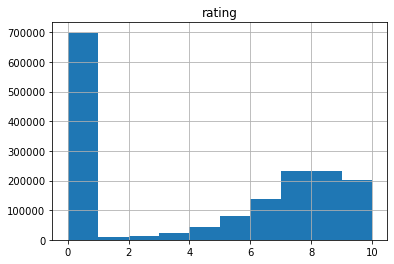

In [324]:
ratings_df.hist(bins=10, column=['rating'])

<AxesSubplot:>

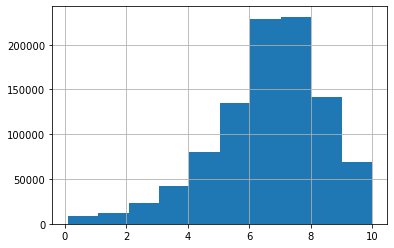

In [325]:
ratings_df.loc[ratings_df['rating'] > 0, 'rating'].hist(bins=10)

In [415]:
len(ratings_df)

1671845

In [413]:
ratings_df.to_csv(f'./data/anime_ratings__500000_10000.csv', sep=';', header=True, index=False, columns=list(ratings_df.axes[1]))